In [1]:
from multi_omics_integration.func import *
from multi_omics_integration.classification_pipeline import *
from multi_omics_integration.processing import *
from multi_omics_integration.evaluation import *
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore', 'Solver terminated early.*')

In [24]:
warnings.filterwarnings('ignore', 'Solver terminated early.*')

In [2]:
datasets = {
            'rna': '../data/kipan/RNASeq.csv',
            'cnv': '../data/kipan/CNV.csv',
            'rppa': '../data/kipan/RPPA.csv',
}
        
labels = '../data/kipan/Clinical.csv'

In [3]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

rna (736, 20190)
cnv (736, 24776)
rppa (736, 166)


# Subtyping

## Preprocessing

### Removing low-variance + null features

In [5]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold(X, percentage=0.10):
    var_thr = VarianceThreshold(threshold=percentage) #Removing both constant and quasi-constant (less than 1% variance)

    X_new = var_thr.fit_transform(X)
    
    column_names = X.columns[var_thr.get_support()]

    return pd.DataFrame(X_new, columns=column_names)

In [6]:
new_data = {}
for modality in data:
    new_data[modality] = variance_threshold(data[modality], percentage=0.05)
    print(modality, new_data[modality].shape)

rna (745, 19391)
cnv (745, 18884)
rppa (745, 130)


In [7]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in new_data:
    X[modality] = pd.DataFrame(new_data[modality])
    X[modality] = X[modality].dropna(axis=1)
    print(modality, X[modality].shape)

rna (745, 19391)
cnv (745, 18884)
rppa (745, 107)


In [9]:
subtypes['histological_type'].value_counts()

kidneyclearcellrenalcarcinoma        469
kidneypapillaryrenalcellcarcinoma    213
kidneychromophobe                     63
Name: histological_type, dtype: int64

In [8]:
enc = LabelEncoder()
y = enc.fit_transform(subtypes['histological_type'])
enc.inverse_transform([0, 1, 2])

array(['kidneychromophobe', 'kidneyclearcellrenalcarcinoma',
       'kidneypapillaryrenalcellcarcinoma'], dtype=object)

## Testing Datasets

In [10]:
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1, sampling_strategy='all', replacement=True)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

estimator_names = [estimator[0] for estimator in estimators]

In [11]:
kipan_scoring = {"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)}

In [15]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring=kipan_scoring)

 25%|██▌       | 1/4 [01:27<04:23, 87.76s/it]

logistic                  accuracy balanced_accuracy               f1    recall (KICH)  \
logistic  0.966 +/- 0.016   0.965 +/- 0.033  0.967 +/- 0.016  0.954 +/- 0.092   

            recall (KIRC)    recall (KIRP)  
logistic  0.964 +/- 0.022  0.977 +/- 0.015  


 50%|█████     | 2/4 [01:44<01:31, 45.75s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.950 +/- 0.015   0.957 +/- 0.024  0.951 +/- 0.015   

                          recall (KICH)    recall (KIRC)    recall (KIRP)  
balanced_random_forest  0.969 +/- 0.062  0.945 +/- 0.025  0.958 +/- 0.017  


 75%|███████▌  | 3/4 [02:43<00:51, 51.91s/it]

deep_nn                 accuracy balanced_accuracy               f1    recall (KICH)  \
deep_nn  0.950 +/- 0.018   0.951 +/- 0.030  0.951 +/- 0.018  0.954 +/- 0.062   

           recall (KIRC)    recall (KIRP)  
deep_nn  0.951 +/- 0.025  0.948 +/- 0.041  


100%|██████████| 4/4 [03:03<00:00, 45.92s/it]


svc             accuracy balanced_accuracy               f1    recall (KICH)  \
svc  0.968 +/- 0.018   0.965 +/- 0.033  0.968 +/- 0.018  0.954 +/- 0.092   

       recall (KIRC)    recall (KIRP)  
svc  0.966 +/- 0.025  0.977 +/- 0.015  


  0%|          | 0/4 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 25%|██▌       | 1/4 [00:57<02:51, 57.30s/it]

logistic                  accuracy balanced_accuracy               f1    recall (KICH)  \
logistic  0.863 +/- 0.021   0.796 +/- 0.041  0.861 +/- 0.022  0.669 +/- 0.118   

            recall (KIRC)    recall (KIRP)  
logistic  0.919 +/- 0.026  0.799 +/- 0.078  


 50%|█████     | 2/4 [01:02<00:52, 26.43s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.878 +/- 0.027   0.870 +/- 0.053  0.882 +/- 0.025   

                          recall (KICH)    recall (KIRC)    recall (KIRP)  
balanced_random_forest  0.844 +/- 0.146  0.879 +/- 0.031  0.887 +/- 0.016  


 75%|███████▌  | 3/4 [01:35<00:29, 29.82s/it]

deep_nn                 accuracy balanced_accuracy               f1    recall (KICH)  \
deep_nn  0.856 +/- 0.028   0.806 +/- 0.066  0.855 +/- 0.029  0.715 +/- 0.169   

           recall (KIRC)    recall (KIRP)  
deep_nn  0.900 +/- 0.041  0.803 +/- 0.081  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

svc             accuracy balanced_accuracy               f1    recall (KICH)  \
svc  0.796 +/- 0.048   0.746 +/- 0.054  0.798 +/- 0.046  0.655 +/- 0.128   

       recall (KIRC)    recall (KIRP)  
svc  0.840 +/- 0.069  0.742 +/- 0.031  


 25%|██▌       | 1/4 [00:00<00:00,  3.06it/s]

logistic                  accuracy balanced_accuracy               f1    recall (KICH)  \
logistic  0.742 +/- 0.005   0.568 +/- 0.018  0.731 +/- 0.010  0.223 +/- 0.036   

            recall (KIRC)    recall (KIRP)  
logistic  0.874 +/- 0.018  0.605 +/- 0.041  


 50%|█████     | 2/4 [00:02<00:03,  1.52s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.897 +/- 0.030   0.881 +/- 0.050  0.899 +/- 0.028   

                          recall (KICH)    recall (KIRC)    recall (KIRP)  
balanced_random_forest  0.874 +/- 0.116  0.923 +/- 0.022  0.845 +/- 0.060  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

deep_nn                 accuracy balanced_accuracy               f1    recall (KICH)  \
deep_nn  0.915 +/- 0.027   0.833 +/- 0.045  0.913 +/- 0.029  0.653 +/- 0.072   

           recall (KIRC)    recall (KIRP)  
deep_nn  0.966 +/- 0.013  0.882 +/- 0.071  
svc             accuracy balanced_accuracy               f1    recall (KICH)  \
svc  0.631 +/- 0.047   0.578 +/- 0.044  0.646 +/- 0.044  0.492 +/- 0.114   

       recall (KIRC)    recall (KIRP)  
svc  0.682 +/- 0.058  0.559 +/- 0.060  


In [20]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['rppa'])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.966 +/- 0.016,0.965 +/- 0.033,0.967 +/- 0.016,0.954 +/- 0.092,0.964 +/- 0.022,0.977 +/- 0.015
balanced_random_forest,0.950 +/- 0.009,0.960 +/- 0.020,0.951 +/- 0.009,0.969 +/- 0.062,0.938 +/- 0.014,0.972 +/- 0.009
deep_nn,0.950 +/- 0.022,0.940 +/- 0.037,0.950 +/- 0.022,0.921 +/- 0.072,0.959 +/- 0.018,0.939 +/- 0.058
svc,0.969 +/- 0.019,0.966 +/- 0.034,0.969 +/- 0.019,0.954 +/- 0.092,0.968 +/- 0.025,0.977 +/- 0.015


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.882 +/- 0.023,0.829 +/- 0.047,0.881 +/- 0.022,0.746 +/- 0.122,0.934 +/- 0.030,0.808 +/- 0.026
balanced_random_forest,0.895 +/- 0.014,0.880 +/- 0.038,0.897 +/- 0.013,0.842 +/- 0.128,0.904 +/- 0.019,0.892 +/- 0.045
deep_nn,0.889 +/- 0.027,0.849 +/- 0.067,0.889 +/- 0.027,0.774 +/- 0.168,0.919 +/- 0.034,0.855 +/- 0.044
svc,0.855 +/- 0.016,0.818 +/- 0.030,0.856 +/- 0.015,0.764 +/- 0.096,0.895 +/- 0.034,0.794 +/- 0.053


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.785 +/- 0.016,0.682 +/- 0.015,0.785 +/- 0.016,0.494 +/- 0.068,0.872 +/- 0.015,0.681 +/- 0.057
balanced_random_forest,0.923 +/- 0.016,0.915 +/- 0.029,0.924 +/- 0.016,0.922 +/- 0.069,0.944 +/- 0.026,0.878 +/- 0.041
deep_nn,0.954 +/- 0.021,0.906 +/- 0.051,0.953 +/- 0.022,0.813 +/- 0.124,0.994 +/- 0.009,0.911 +/- 0.028
svc,0.752 +/- 0.016,0.712 +/- 0.039,0.761 +/- 0.013,0.669 +/- 0.145,0.804 +/- 0.032,0.662 +/- 0.056


(None, None, None)

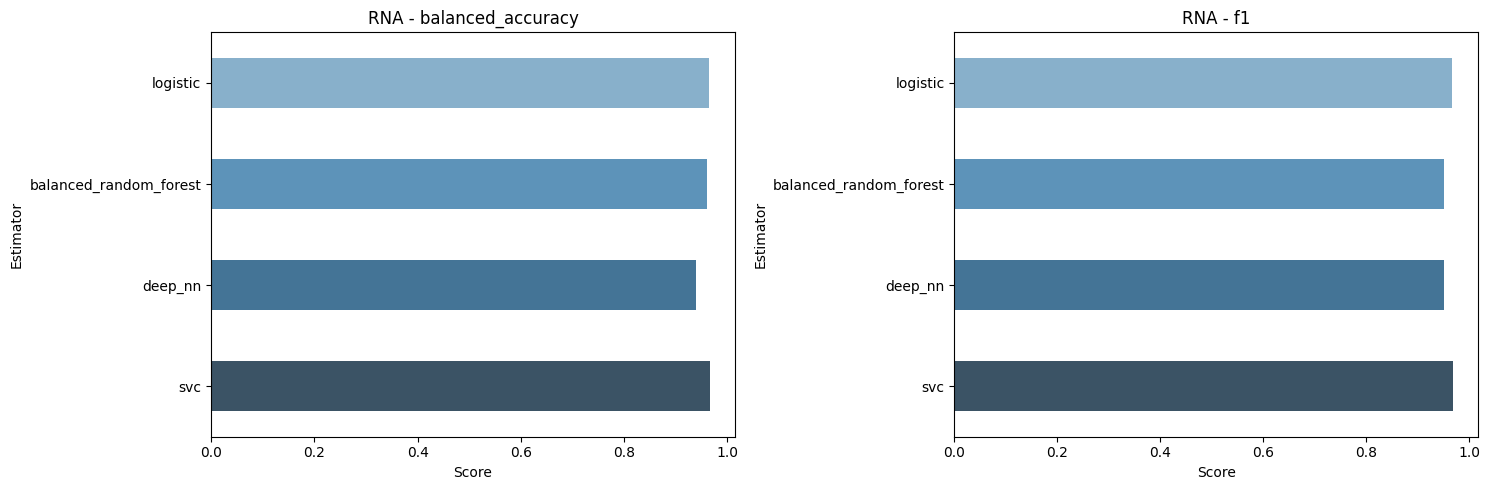

In [23]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

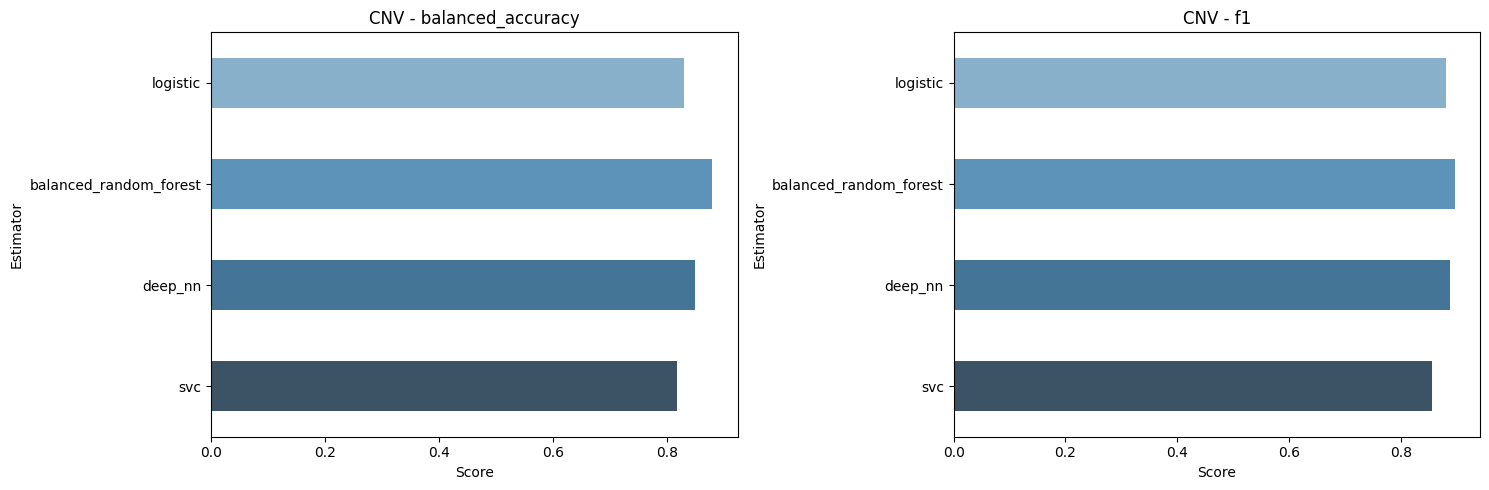

In [24]:
plot_bar_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

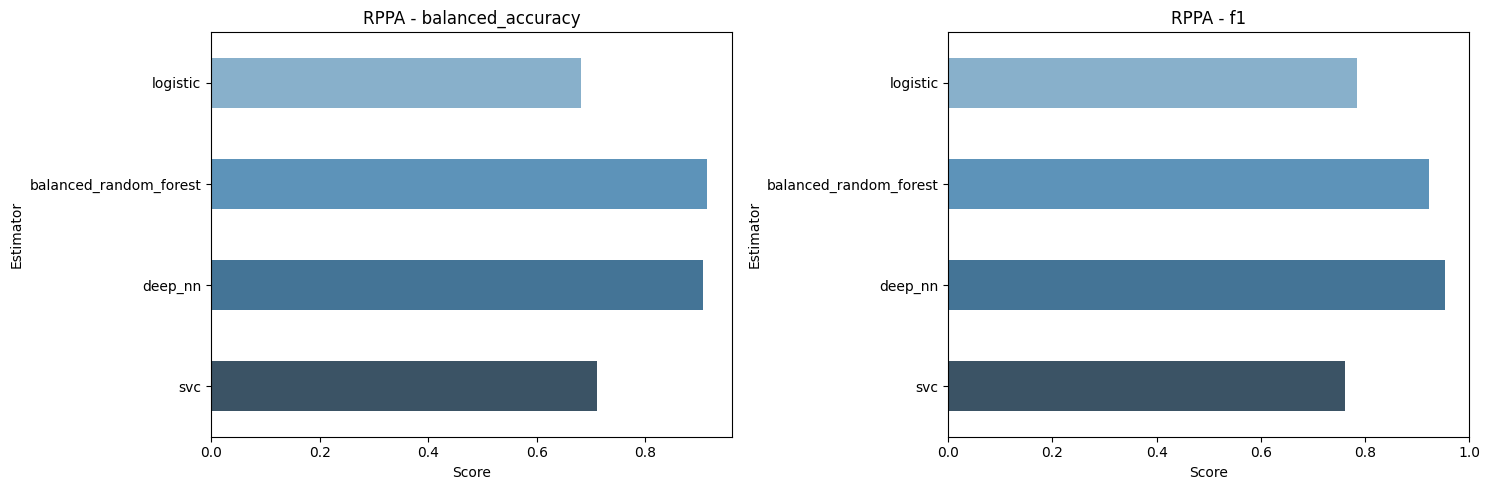

In [25]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

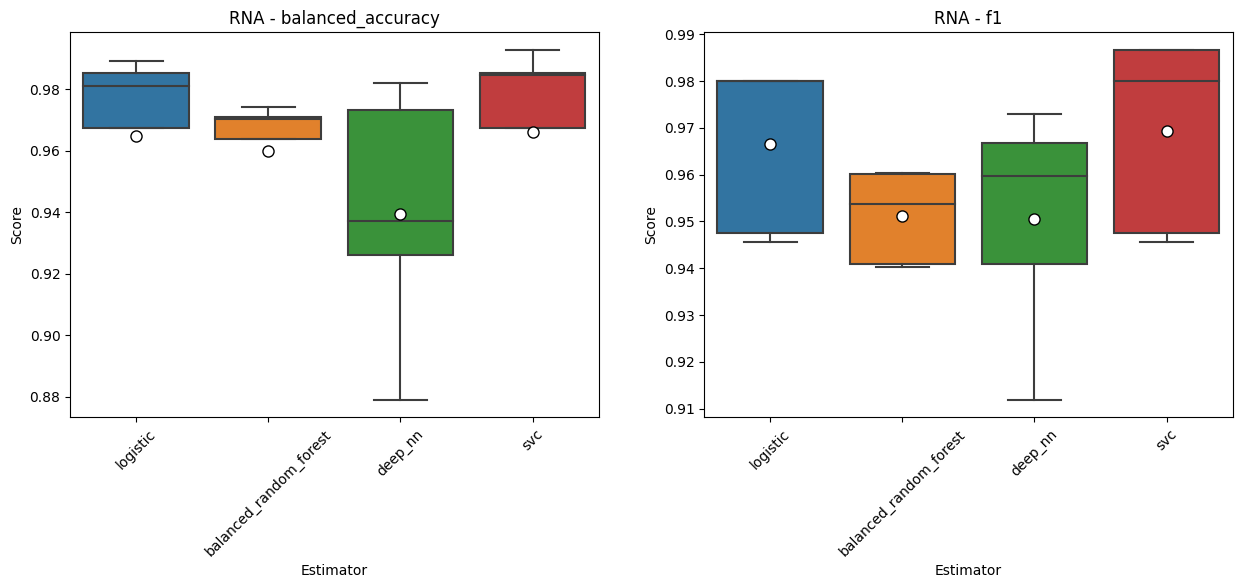

In [26]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

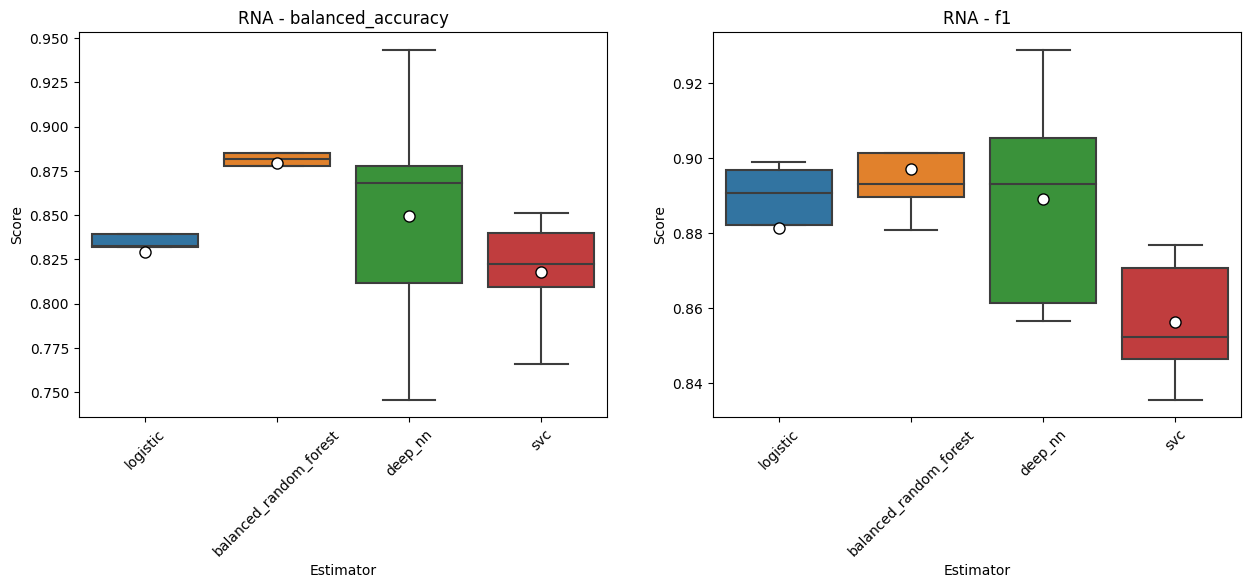

In [27]:
plot_box_scores(estimator_names, base_scores['cnv'], 'RNA', metrics=['balanced_accuracy', 'f1'])

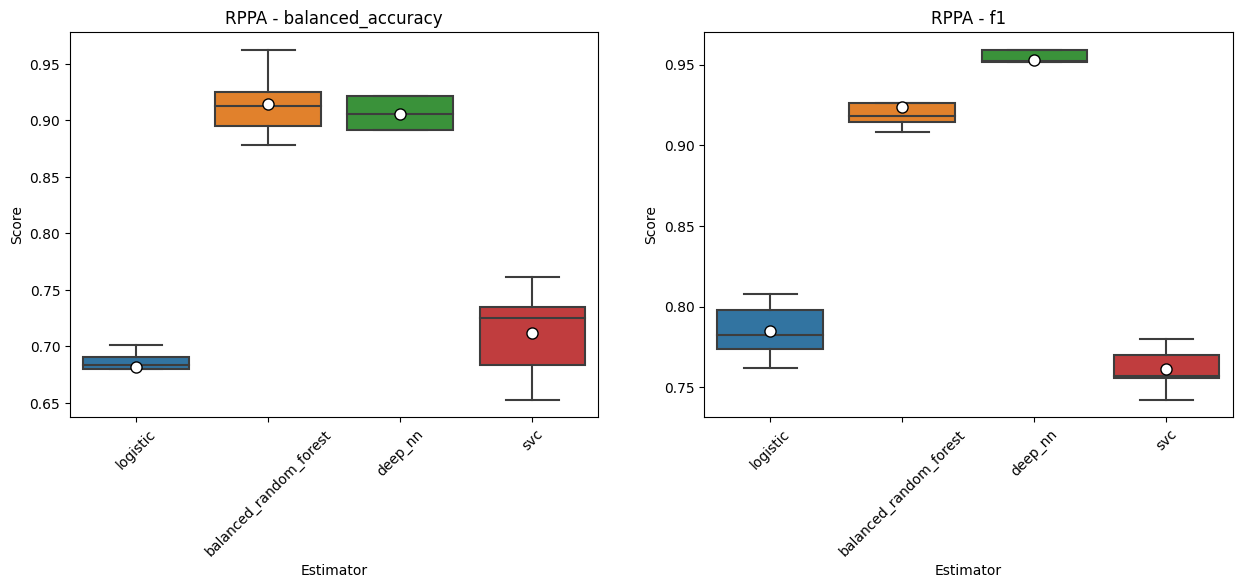

In [28]:
plot_box_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

## Modality Ensembles

In [26]:
from multi_omics_integration.classification_pipeline import Debugger

class ModalityPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, estimator_list=None, feature_select=None, final_estimator=LogisticRegression(random_state=0, n_jobs=-1), cv=5, n_jobs=-1, stack_method='auto'):
        self.cv = cv
        self.estimator_list = estimator_list
        self.feature_select = feature_select
        self.final_estimator = final_estimator
        self.n_jobs=n_jobs
        self.stack_method = stack_method
        
    def _get_model(self):
        self.cv_ = StratifiedKFold(n_splits=self.cv, random_state=0, shuffle=True)
        self.final_estimator_ = Pipeline([('imputer', SimpleImputer(strategy='median')), ('final', self.final_estimator)])
        
        stacking = StackingClassifier(estimators=self.estimator_list, final_estimator=self.final_estimator_, cv=self.cv_, stack_method=self.stack_method, n_jobs=self.n_jobs)
        
        if self.feature_select != None:
            model = Pipeline([('feature_selection', self.feature_select), ('clf', stacking)])
        else:
            model = stacking
        
        return model
    
    def fit(self, X, y):
        self.model_ = self._get_model()
        self.model_.fit(X, y)
        self.classes_ = self.model_.classes_
        self.coef_ = self.model_.final_estimator_.named_steps['final'].coef_
        
        return self
    
    def predict(self, X):
        return self.model_.predict(X)
    
    def predict_proba(self, X):
        return self.model_.predict_proba(X)

In [17]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [31]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring=kipan_scoring)
    modality_metrics = pd.concat([modality_metrics, df])
    print(df)

 33%|███▎      | 1/3 [06:35<13:10, 395.19s/it]

            accuracy balanced_accuracy               f1    recall (KICH)  \
rna  0.968 +/- 0.018   0.961 +/- 0.032  0.968 +/- 0.018  0.937 +/- 0.090   

       recall (KIRC)    recall (KIRP)  
rna  0.968 +/- 0.025  0.977 +/- 0.015  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

            accuracy balanced_accuracy               f1    recall (KICH)  \
cnv  0.915 +/- 0.020   0.895 +/- 0.046  0.916 +/- 0.020  0.858 +/- 0.132   

       recall (KIRC)    recall (KIRP)  
cnv  0.934 +/- 0.022  0.893 +/- 0.058  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

             accuracy balanced_accuracy               f1    recall (KICH)  \
rppa  0.957 +/- 0.017   0.918 +/- 0.037  0.956 +/- 0.018  0.844 +/- 0.084   

        recall (KIRC)    recall (KIRP)  
rppa  0.987 +/- 0.016  0.925 +/- 0.035  


In [32]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.968 +/- 0.018,0.961 +/- 0.032,0.968 +/- 0.018,0.937 +/- 0.090,0.968 +/- 0.025,0.977 +/- 0.015
cnv,0.915 +/- 0.020,0.895 +/- 0.046,0.916 +/- 0.020,0.858 +/- 0.132,0.934 +/- 0.022,0.893 +/- 0.058
rppa,0.957 +/- 0.017,0.918 +/- 0.037,0.956 +/- 0.018,0.844 +/- 0.084,0.987 +/- 0.016,0.925 +/- 0.035


In [33]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.968 +/- 0.018,0.960 +/- 0.037,0.968 +/- 0.018,0.938 +/- 0.090,0.970 +/- 0.018,0.972 +/- 0.018
cnv,0.893 +/- 0.029,0.851 +/- 0.060,0.892 +/- 0.030,0.781 +/- 0.147,0.932 +/- 0.023,0.841 +/- 0.056
rppa,0.936 +/- 0.026,0.883 +/- 0.051,0.934 +/- 0.028,0.781 +/- 0.099,0.977 +/- 0.008,0.891 +/- 0.064


In [33]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]

all_scores = base_scores
all_scores['rna'].append(scores['rna'])
all_scores['cnv'].append(scores['cnv'])
all_scores['rppa'].append(scores['rppa'])

### Scoring

In [34]:
all_metrics = {}

for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [35]:
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['rppa'])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.966 +/- 0.016,0.965 +/- 0.033,0.967 +/- 0.016,0.954 +/- 0.092,0.964 +/- 0.022,0.977 +/- 0.015
balanced_random_forest,0.950 +/- 0.009,0.960 +/- 0.020,0.951 +/- 0.009,0.969 +/- 0.062,0.938 +/- 0.014,0.972 +/- 0.009
deep_nn,0.950 +/- 0.022,0.940 +/- 0.037,0.950 +/- 0.022,0.921 +/- 0.072,0.959 +/- 0.018,0.939 +/- 0.058
svc,0.969 +/- 0.019,0.966 +/- 0.034,0.969 +/- 0.019,0.954 +/- 0.092,0.968 +/- 0.025,0.977 +/- 0.015
rna,0.968 +/- 0.018,0.961 +/- 0.032,0.968 +/- 0.018,0.937 +/- 0.090,0.968 +/- 0.025,0.977 +/- 0.015


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.882 +/- 0.023,0.829 +/- 0.047,0.881 +/- 0.022,0.746 +/- 0.122,0.934 +/- 0.030,0.808 +/- 0.026
balanced_random_forest,0.895 +/- 0.014,0.880 +/- 0.038,0.897 +/- 0.013,0.842 +/- 0.128,0.904 +/- 0.019,0.892 +/- 0.045
deep_nn,0.889 +/- 0.027,0.849 +/- 0.067,0.889 +/- 0.027,0.774 +/- 0.168,0.919 +/- 0.034,0.855 +/- 0.044
svc,0.855 +/- 0.016,0.818 +/- 0.030,0.856 +/- 0.015,0.764 +/- 0.096,0.895 +/- 0.034,0.794 +/- 0.053
cnv,0.915 +/- 0.020,0.895 +/- 0.046,0.916 +/- 0.020,0.858 +/- 0.132,0.934 +/- 0.022,0.893 +/- 0.058


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.785 +/- 0.016,0.682 +/- 0.015,0.785 +/- 0.016,0.494 +/- 0.068,0.872 +/- 0.015,0.681 +/- 0.057
balanced_random_forest,0.923 +/- 0.016,0.915 +/- 0.029,0.924 +/- 0.016,0.922 +/- 0.069,0.944 +/- 0.026,0.878 +/- 0.041
deep_nn,0.954 +/- 0.021,0.906 +/- 0.051,0.953 +/- 0.022,0.813 +/- 0.124,0.994 +/- 0.009,0.911 +/- 0.028
svc,0.752 +/- 0.016,0.712 +/- 0.039,0.761 +/- 0.013,0.669 +/- 0.145,0.804 +/- 0.032,0.662 +/- 0.056
rppa,0.957 +/- 0.017,0.918 +/- 0.037,0.956 +/- 0.018,0.844 +/- 0.084,0.987 +/- 0.016,0.925 +/- 0.035


In [36]:
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['rppa'])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.966 +/- 0.016,0.965 +/- 0.033,0.967 +/- 0.016,0.954 +/- 0.092,0.964 +/- 0.022,0.977 +/- 0.015
balanced_random_forest,0.950 +/- 0.015,0.957 +/- 0.027,0.951 +/- 0.015,0.969 +/- 0.062,0.945 +/- 0.021,0.958 +/- 0.023
deep_nn,0.950 +/- 0.018,0.951 +/- 0.030,0.951 +/- 0.018,0.954 +/- 0.062,0.951 +/- 0.025,0.948 +/- 0.041
svc,0.968 +/- 0.018,0.965 +/- 0.033,0.968 +/- 0.018,0.954 +/- 0.092,0.966 +/- 0.025,0.977 +/- 0.015
rna,0.968 +/- 0.018,0.960 +/- 0.037,0.968 +/- 0.018,0.938 +/- 0.090,0.970 +/- 0.018,0.972 +/- 0.018


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.863 +/- 0.021,0.796 +/- 0.041,0.861 +/- 0.022,0.669 +/- 0.118,0.919 +/- 0.026,0.799 +/- 0.078
balanced_random_forest,0.867 +/- 0.025,0.865 +/- 0.045,0.872 +/- 0.023,0.859 +/- 0.112,0.868 +/- 0.027,0.869 +/- 0.031
deep_nn,0.856 +/- 0.028,0.806 +/- 0.066,0.855 +/- 0.029,0.715 +/- 0.169,0.900 +/- 0.041,0.803 +/- 0.081
svc,0.796 +/- 0.048,0.746 +/- 0.054,0.798 +/- 0.046,0.655 +/- 0.128,0.840 +/- 0.069,0.742 +/- 0.031
cnv,0.893 +/- 0.029,0.851 +/- 0.060,0.892 +/- 0.030,0.781 +/- 0.147,0.932 +/- 0.023,0.841 +/- 0.056


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.742 +/- 0.005,0.568 +/- 0.018,0.731 +/- 0.010,0.223 +/- 0.036,0.874 +/- 0.018,0.605 +/- 0.041
balanced_random_forest,0.882 +/- 0.038,0.891 +/- 0.031,0.888 +/- 0.033,0.921 +/- 0.072,0.880 +/- 0.045,0.873 +/- 0.047
deep_nn,0.915 +/- 0.027,0.833 +/- 0.045,0.913 +/- 0.029,0.653 +/- 0.072,0.966 +/- 0.013,0.882 +/- 0.071
svc,0.631 +/- 0.047,0.578 +/- 0.044,0.646 +/- 0.044,0.492 +/- 0.114,0.682 +/- 0.058,0.559 +/- 0.060
rppa,0.936 +/- 0.026,0.883 +/- 0.051,0.934 +/- 0.028,0.781 +/- 0.099,0.977 +/- 0.008,0.891 +/- 0.064


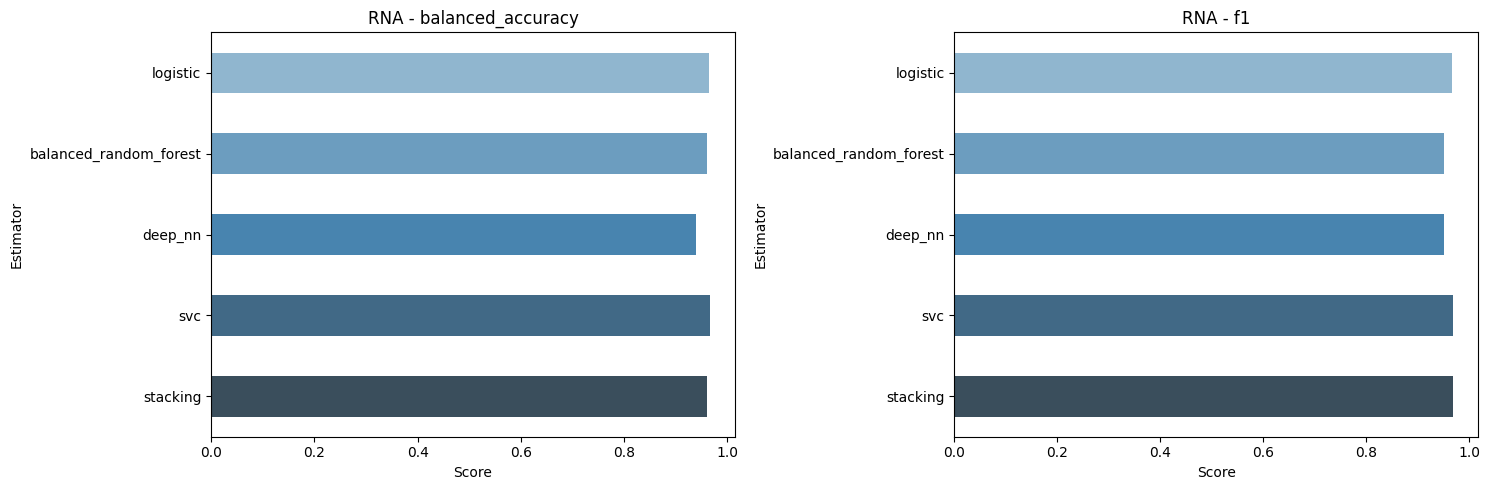

In [36]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

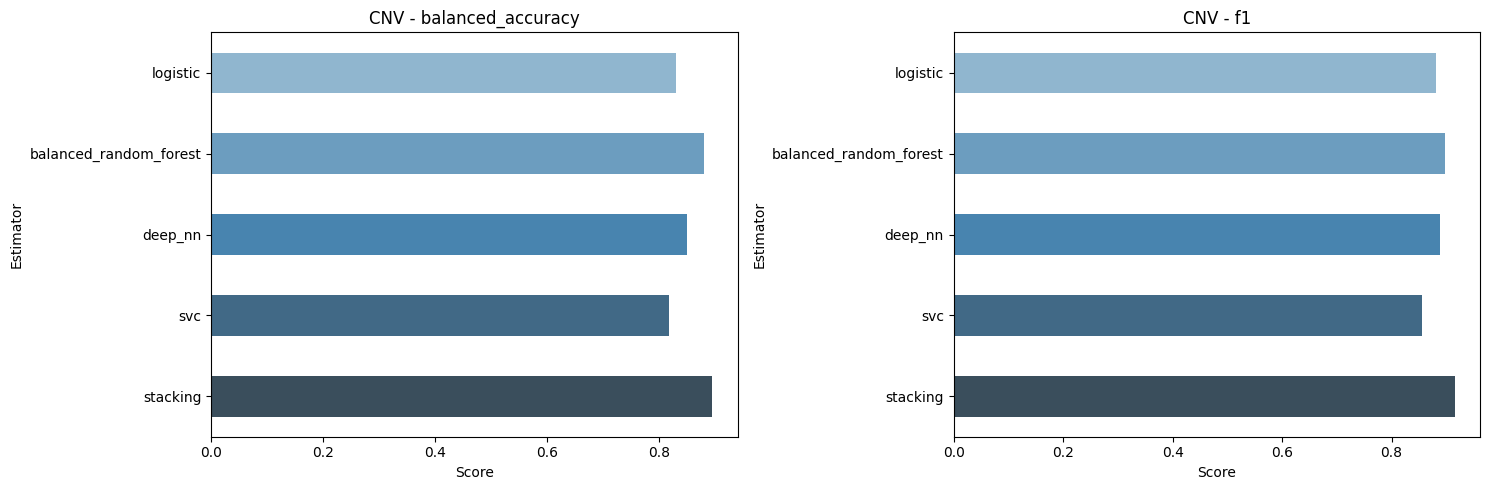

In [37]:
plot_bar_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

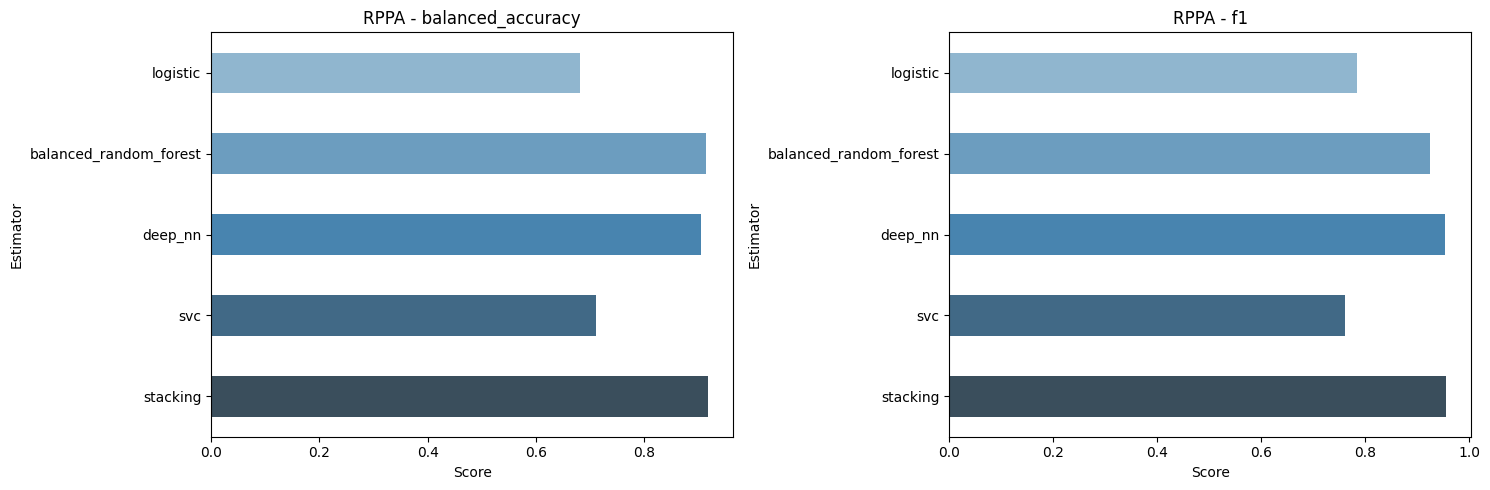

In [38]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

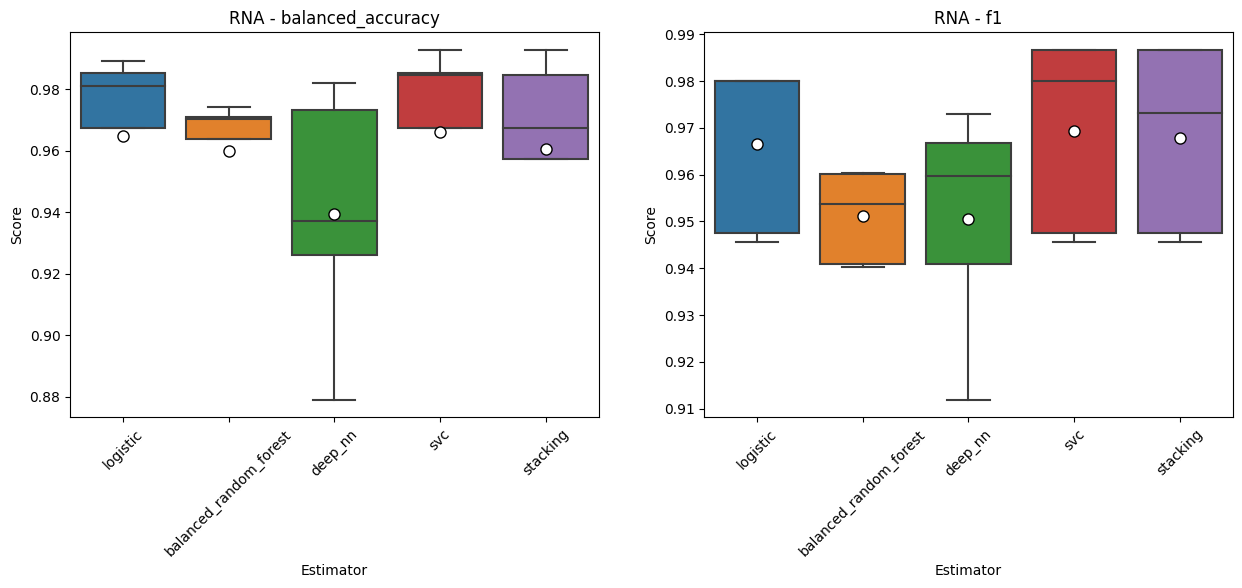

In [39]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

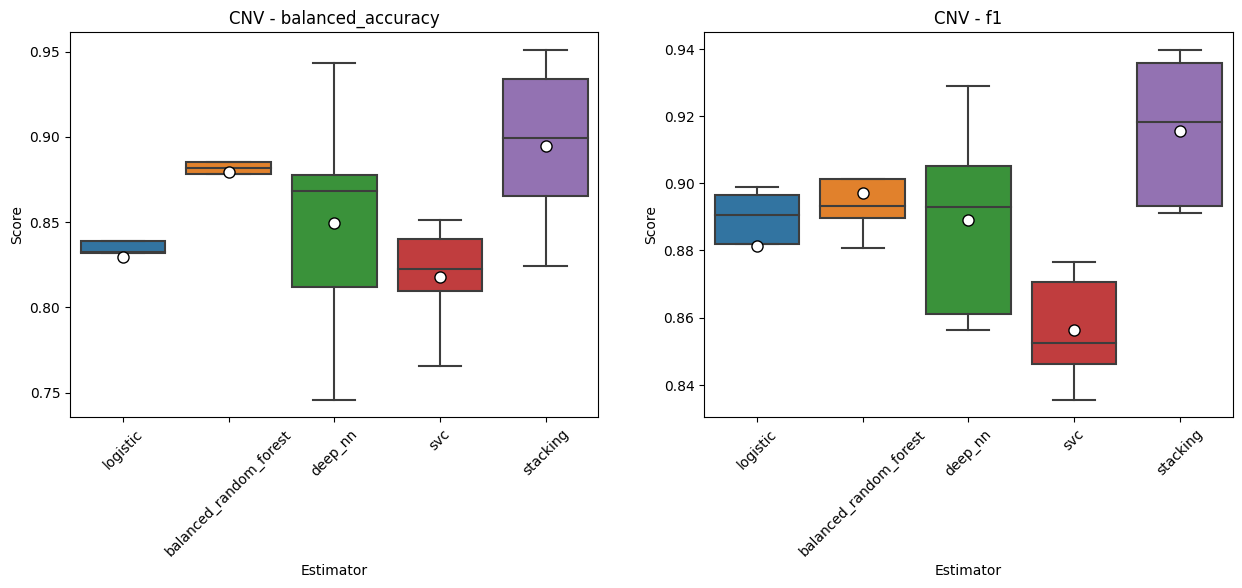

In [40]:
plot_box_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

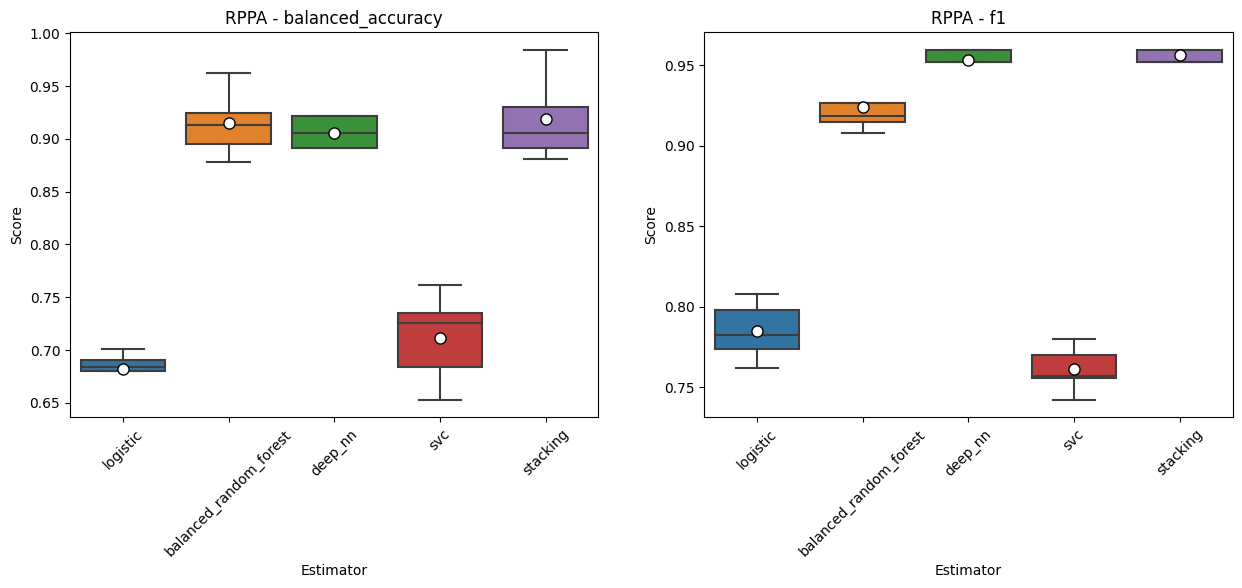

In [41]:
plot_box_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

## Multi Omics Integration Ensemble

### Cross Val Predict

In [ ]:
preds = {}

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

for modality in tqdm(datasets):
    preds[modality] = cross_val_predict(classifiers[modality], X[modality], y, cv=skf, n_jobs=-1, method ='predict_proba')

In [46]:
# Making dataframe of predicted class out of probabilities
preds_class_df = pd.DataFrame({
    'rna': preds['rna'].argmax(axis=1),
    'cnv': preds['cnv'].argmax(axis=1),
    'rppa': preds['rppa'].argmax(axis=1)
})

# Making dataframe of predicted probabilities
preds_proba_df = pd.concat([pd.DataFrame(preds['rna'], columns=['rna_KICH', 'rna_KIRC', 'rna_KIRP']), pd.DataFrame(preds['cnv'], columns=['cnv_KICH', 'cnv_KIRC', 'cnv_KIRP']), pd.DataFrame(preds['rppa'], columns=['rppa_KICH', 'rppa_KIRC', 'rppa_KIRP'])], axis=1)

In [47]:
preds_class_df

,rna,cnv,rppa
0,0,0,0
1,0,0,0
2,0,2,0
3,0,0,0
4,0,0,1
...,...,...,...
740,2,2,2
741,2,2,2
742,2,1,2
743,2,2,2


In [48]:
preds_proba_df

,rna_KICH,rna_KIRC,rna_KIRP,cnv_KICH,cnv_KIRC,cnv_KIRP,rppa_KICH,rppa_KIRC,rppa_KIRP
0,0.915607,0.045604,0.038789,0.898000,0.076016,0.025984,0.664656,0.089507,0.245838
1,0.862500,0.129541,0.007958,0.909660,0.066129,0.024211,0.927931,0.022498,0.049571
2,0.937118,0.030343,0.032540,0.089807,0.317458,0.592735,0.972242,0.021291,0.006467
3,0.849237,0.139902,0.010861,0.602241,0.310769,0.086990,0.895499,0.060093,0.044409
4,0.935229,0.026760,0.038010,0.955289,0.034666,0.010045,0.283692,0.399620,0.316688
...,...,...,...,...,...,...,...,...,...
740,0.004060,0.020598,0.975342,0.048437,0.222579,0.728984,0.007751,0.012599,0.979650
741,0.003511,0.014863,0.981625,0.007451,0.031505,0.961043,0.010171,0.020882,0.968948
742,0.008283,0.026506,0.965211,0.014118,0.946792,0.039090,0.283740,0.030794,0.685466
743,0.006007,0.021183,0.972810,0.008341,0.027612,0.964047,0.004768,0.004171,0.991062


With Voting:

In [108]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Find the majority class for each sample
majority_class = pred_df.mode(axis=1)[0]

# Calculate the scores
accuracy = accuracy_score(y, majority_class)
f1 = f1_score(y, majority_class, average='weighted')
recall = recall_score(y, majority_class, average=None)

scores_df = pd.DataFrame({'accuracy': [accuracy], 'f1': [f1], 'recall (KICH)': [recall[0]], 'recall (KIRC)': [recall[1]], 'recall (KIRP)': [recall[2]]})

# Combine scores_df with modality_metrics
integration_voting_metrics = pd.concat([modality_metrics, scores_df.rename(index={0: 'majority_class'})])

integration_voting_metrics


,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.968 +/- 0.018,0.968 +/- 0.018,0.954 +/- 0.092,0.968 +/- 0.025,0.972 +/- 0.023
cnv,0.882 +/- 0.034,0.881 +/- 0.033,0.732 +/- 0.112,0.925 +/- 0.041,0.831 +/- 0.053
rppa,0.945 +/- 0.027,0.943 +/- 0.028,0.733 +/- 0.086,0.985 +/- 0.009,0.920 +/- 0.072
majority_class,0.969128,0.969151,0.936508,0.976546,0.962441


With Stacking:

In [ ]:
integration_scores, integration_metrics = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_class_df, y, name='Integration Model', cv=5, verbose=2, scoring={"accuracy": "accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})

In [51]:
integration_metrics

,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
Integration Model,0.961 +/- 0.026,0.961 +/- 0.027,0.892 +/- 0.115,0.979 +/- 0.018,0.944 +/- 0.036


In [103]:
names = ['cnv', 'rna', 'rppa', 'integration']
integration = []
integration.append(scores['cnv'])
integration.append(scores['rna'])
integration.append(scores['rppa'])
integration.append(integration_scores)

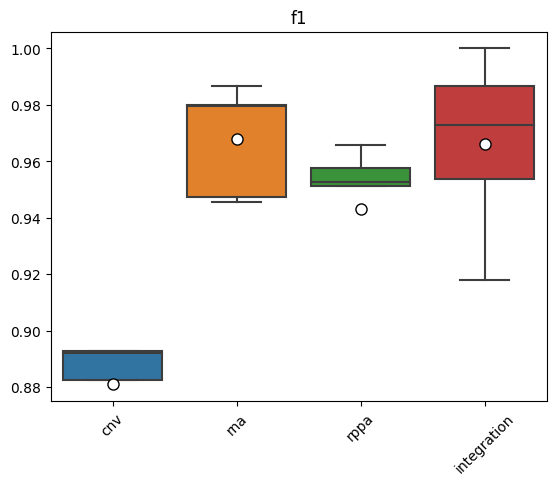

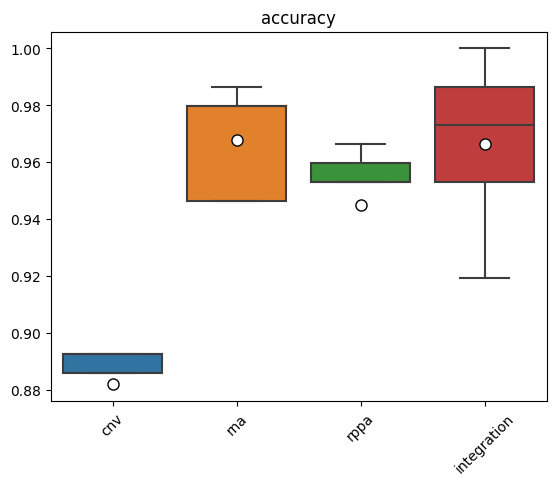

In [104]:
plot_scores(names, integration)

In [ ]:
rna_cnv_rppa_scores, rna_cnv_rppa_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df, y, name='rna + cnv + rppa', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})
cnv_rppa_scores, cnv_rppa_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['cnv_KICH', 'cnv_KIRC', 'cnv_KIRP', 'rppa_KICH', 'rppa_KIRC', 'rppa_KIRP']], y, name='cnv + rppa', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})
rna_rppa_scores, rna_rppa_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_KICH', 'rna_KIRC', 'rna_KIRP', 'rppa_KICH', 'rppa_KIRC', 'rppa_KIRP']], y, name='rna + rppa', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})
rna_cnv_scores, rna_cnv_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_KICH', 'rna_KIRC', 'rna_KIRP', 'cnv_KICH', 'cnv_KIRC', 'cnv_KIRP']], y, name='rna + cnv', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})

In [53]:
integration_stacking_metrics = pd.concat([modality_metrics, rna_cnv_rppa_df, cnv_rppa_df, rna_rppa_df, rna_cnv_df])

In [54]:
integration_stacking_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.968 +/- 0.018,0.960 +/- 0.037,0.968 +/- 0.018,0.938 +/- 0.090,0.970 +/- 0.018,0.972 +/- 0.018
cnv,0.893 +/- 0.029,0.851 +/- 0.060,0.892 +/- 0.030,0.781 +/- 0.147,0.932 +/- 0.023,0.841 +/- 0.056
rppa,0.936 +/- 0.026,0.883 +/- 0.051,0.934 +/- 0.028,0.781 +/- 0.099,0.977 +/- 0.008,0.891 +/- 0.064
rna + cnv + rppa,0.976 +/- 0.021,0.961 +/- 0.036,0.976 +/- 0.021,0.923 +/- 0.084,0.983 +/- 0.017,0.976 +/- 0.015
cnv + rppa,0.966 +/- 0.014,0.934 +/- 0.038,0.966 +/- 0.015,0.860 +/- 0.101,0.985 +/- 0.011,0.958 +/- 0.023
rna + rppa,0.976 +/- 0.016,0.961 +/- 0.034,0.976 +/- 0.016,0.923 +/- 0.084,0.983 +/- 0.014,0.977 +/- 0.021
rna + cnv,0.968 +/- 0.018,0.959 +/- 0.036,0.968 +/- 0.018,0.938 +/- 0.090,0.972 +/- 0.020,0.967 +/- 0.024


In [58]:
names = ['rna', 'cnv', 'rppa', 'rna + cnv + rppa', 'cnv + rppa', 'rna + rppa', 'rna + cnv']
integration = []
integration.append(scores['rna'])
integration.append(scores['cnv'])
integration.append(scores['rppa'])
integration.append(rna_cnv_rppa_scores)
integration.append(cnv_rppa_scores)
integration.append(rna_rppa_scores)
integration.append(rna_cnv_scores)

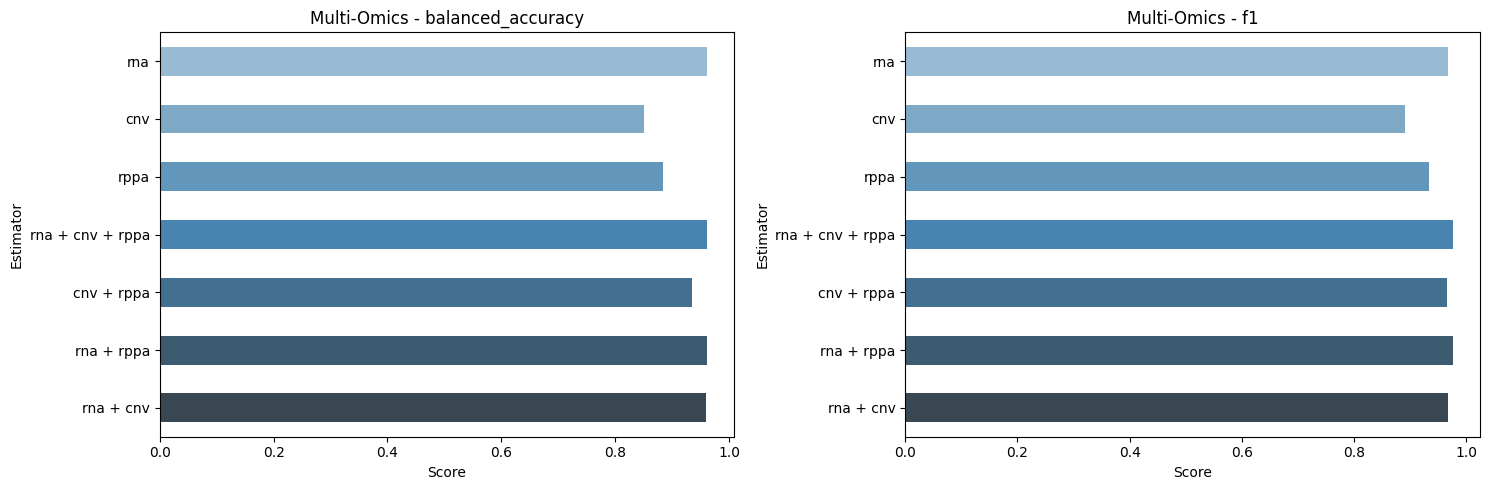

In [59]:
plot_bar_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

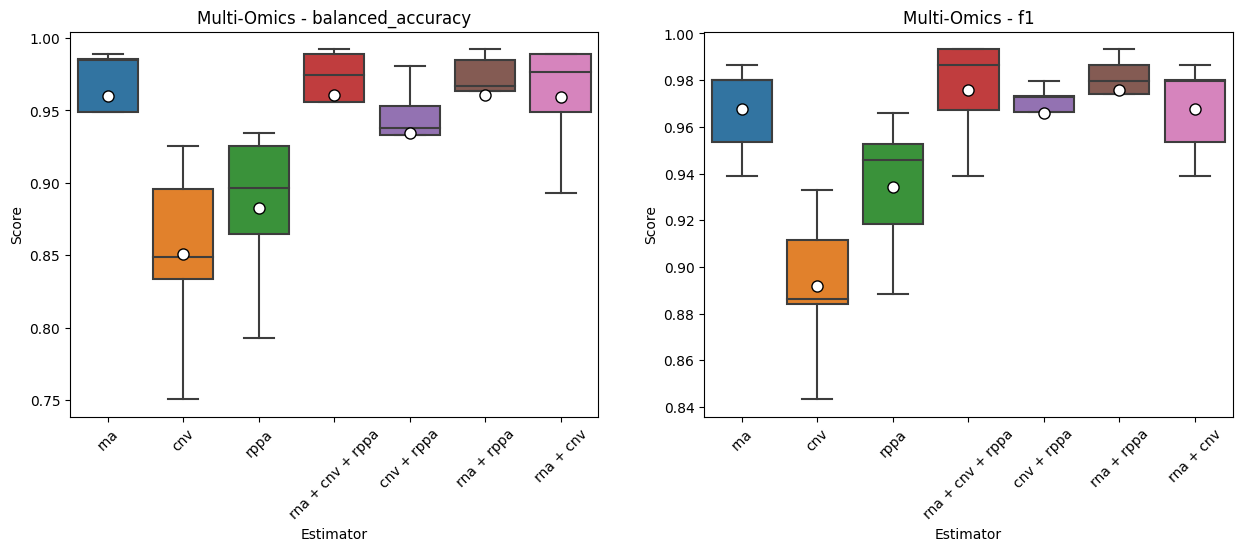

In [60]:
plot_box_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

### Ensemble Model as a Custom Classifier

In [18]:
from mlxtend.feature_selection import ColumnSelector

class MultiOmicsIntegrationClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, estimator_dict=None, feature_select=None, final_estimator=LogisticRegression(random_state=0, n_jobs=-1), stack_method='auto', cv=5, n_jobs=-1):
        # calculating scores
        self.estimator_dict = estimator_dict
        self.feature_select = feature_select
        self.final_estimator = final_estimator
        self.stack_method = stack_method
        self.cv = cv
        self.n_jobs = n_jobs
        
    def _get_pipeline(self):
        self.classifiers_ = []
        self.cv_ = StratifiedKFold(n_splits=self.cv, random_state=0, shuffle=True)
        
        for dataset, columns in self.column_names_.items():
            stacking = Pipeline([('column_selector', ColumnSelector(cols=columns)), ('modality_clf', self.estimator_dict[dataset])])
            self.classifiers_.append((dataset, stacking))
        
        self.final_estimator_ = Pipeline([('imputer', SimpleImputer(strategy='median')), ('final_estimator', self.final_estimator)])
        stacking = StackingClassifier(estimators=self.classifiers_, final_estimator=self.final_estimator_, cv=self.cv_, stack_method=self.stack_method, n_jobs=self.n_jobs)
        
        return stacking
    
    def fit(self, X, y, column_names=None, **fit_params):
        
        self.column_names_ = column_names

        self.pipeline_ = self._get_pipeline()
        self.pipeline_.fit(X, y)

        return self
    
    def predict(self, X):
        return self.pipeline_.predict(X)
    
    def predict_proba(self, X):
        return self.pipeline_.predict_proba(X)

In [19]:
column_names = {}

for key in X.keys():
    column_names[key] = X[key].columns

In [20]:
meta_ensembles = {}
meta_ensembles['rna + cnv + rppa'] = MultiOmicsIntegrationClassifier(classifiers, cv=3)
meta_ensembles['cnv + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['cnv', 'rppa']}, cv=3)
meta_ensembles['rna + cnv'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'cnv']}, cv=3)
meta_ensembles['rna + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'rppa']}, cv=3)

In [21]:
X_merged = {}
X_merged['rna + cnv + rppa'] = pd.concat([X['rna'], X['cnv'], X['rppa']], axis=1, join='inner')
X_merged['cnv + rppa'] = pd.concat([X['cnv'], X['rppa']], axis=1, join='inner')
X_merged['rna + cnv'] = pd.concat([X['rna'], X['cnv']], axis=1, join='inner')
X_merged['rna + rppa'] = pd.concat([X['rna'], X['rppa']], axis=1, join='inner')


In [22]:
integration_scores = {}
integration_metrics = {}

In [23]:
integration_scores['rna + cnv + rppa'], integration_metrics['rna + cnv + rppa'] = get_cross_metrics(meta_ensembles['rna + cnv + rppa'], X_merged['rna + cnv + rppa'], y, name='rna + cnv + rppa', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': column_names})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with Stand

In [ ]:
integration_stacking_metrics = pd.concat([modality_metrics, integration_metrics['rna + cnv + rppa']])
integration_stacking_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.912 +/- 0.034,0.891 +/- 0.057,0.910 +/- 0.036,0.972 +/- 0.034,0.833 +/- 0.183,0.947 +/- 0.023,0.810 +/- 0.120
mirna,0.821 +/- 0.022,0.779 +/- 0.041,0.814 +/- 0.026,0.958 +/- 0.057,0.667 +/- 0.211,0.900 +/- 0.059,0.590 +/- 0.150
methylation,0.833 +/- 0.053,0.807 +/- 0.063,0.830 +/- 0.057,0.958 +/- 0.034,0.733 +/- 0.082,0.886 +/- 0.032,0.650 +/- 0.161
Integration Model,0.912 +/- 0.022,0.897 +/- 0.022,0.910 +/- 0.023,0.972 +/- 0.034,0.867 +/- 0.125,0.947 +/- 0.023,0.800 +/- 0.114


In [ ]:
integration_scores['cnv + rppa'], integration_metrics['cnv + rppa'] = get_cross_metrics(meta_ensembles['cnv + rppa'], X_merged['cnv + rppa'], y, name='cnv + rppa', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': column_names})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the 

[CV] END .................................................... total time= 1.3min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentat

[CV] END .................................................... total time= 1.3min
[CV] END .................................................... total time= 1.3min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


[CV] END .................................................... total time= 1.3min
[CV] END .................................................... total time= 1.3min


In [ ]:
integration_scores['rna + rppa'], integration_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': column_names})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to conv

[CV] END .................................................... total time=11.1min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=11.3min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 11.4min remaining: 17.0min


[CV] END .................................................... total time=11.2min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=11.3min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=11.5min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.6min finished


In [ ]:
integration_scores['rna + cnv'], integration_metrics['rna + cnv'] = get_cross_metrics(meta_ensembles['rna + cnv'], X_merged['rna + cnv'], y, name='rna + cnv', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': column_names})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation f

[CV] END .................................................... total time= 9.9min
[CV] END .................................................... total time=10.1min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.2min remaining: 15.3min
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentat

[CV] END .................................................... total time=10.1min
[CV] END .................................................... total time=10.2min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=10.3min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.3min finished


In [ ]:
class_integration_stacking_metrics = pd.concat([modality_metrics, integration_metrics.values()])
names = ['rna', 'cnv', 'rppa', 'rna + cnv + rppa', 'cnv + rppa', 'rna + rppa', 'rna + cnv']

class_integration = []
class_integration.append(scores['rna'])
class_integration.append(scores['cnv'])
class_integration.append(scores['rppa'])

for name, value in integration_scores.items():
    class_integration.append(value)

In [ ]:
class_integration_stacking_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.912 +/- 0.034,0.891 +/- 0.057,0.910 +/- 0.036,0.972 +/- 0.034,0.833 +/- 0.183,0.947 +/- 0.023,0.810 +/- 0.120
mirna,0.821 +/- 0.022,0.779 +/- 0.041,0.814 +/- 0.026,0.958 +/- 0.057,0.667 +/- 0.211,0.900 +/- 0.059,0.590 +/- 0.150
methylation,0.833 +/- 0.053,0.807 +/- 0.063,0.830 +/- 0.057,0.958 +/- 0.034,0.733 +/- 0.082,0.886 +/- 0.032,0.650 +/- 0.161
rna + mirna + meth,0.912 +/- 0.022,0.897 +/- 0.022,0.910 +/- 0.023,0.972 +/- 0.034,0.867 +/- 0.125,0.947 +/- 0.023,0.800 +/- 0.114
mirna + meth,0.851 +/- 0.021,0.826 +/- 0.031,0.849 +/- 0.020,0.958 +/- 0.057,0.767 +/- 0.133,0.908 +/- 0.054,0.670 +/- 0.081
rna + meth,0.914 +/- 0.020,0.898 +/- 0.027,0.912 +/- 0.022,0.972 +/- 0.034,0.867 +/- 0.125,0.952 +/- 0.017,0.800 +/- 0.105
rna + mirna,0.909 +/- 0.020,0.888 +/- 0.008,0.908 +/- 0.021,0.972 +/- 0.034,0.833 +/- 0.105,0.947 +/- 0.023,0.800 +/- 0.114


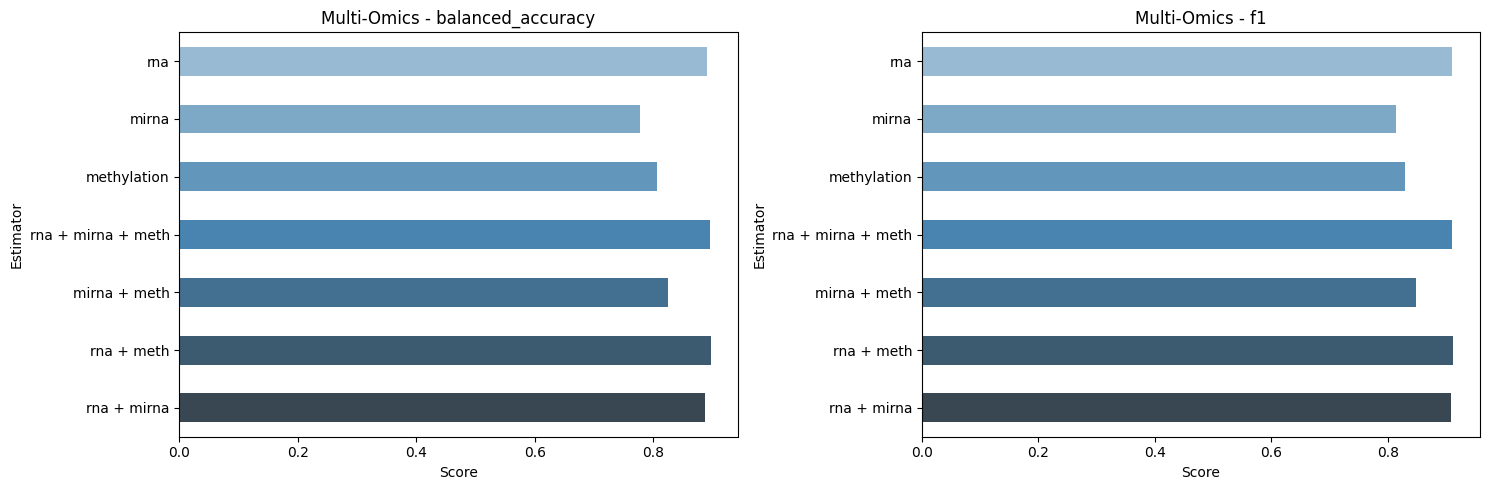

In [ ]:
plot_bar_scores(names, class_integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

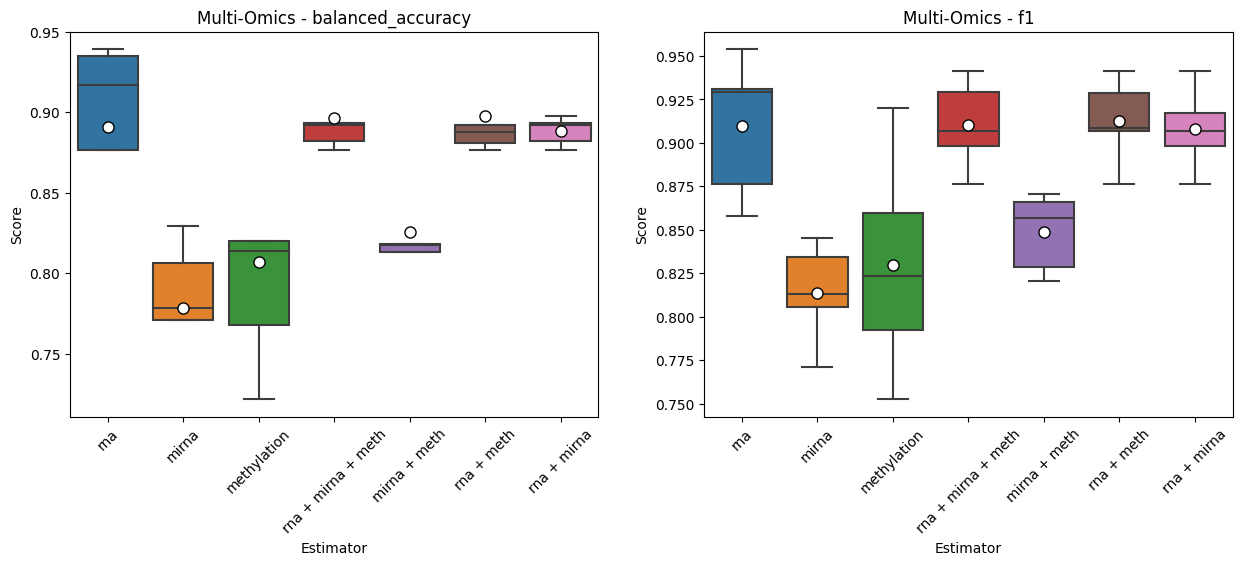

In [ ]:
plot_box_scores(names, class_integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

# Staging

## Preprocessing

### Removing low-variance + null features

In [4]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold(X, percentage=0.10):
    var_thr = VarianceThreshold(threshold=percentage) #Removing both constant and quasi-constant (less than 1% variance)

    X_new = var_thr.fit_transform(X)
    
    column_names = X.columns[var_thr.get_support()]

    return pd.DataFrame(X_new, columns=column_names)

In [5]:
new_data = {}
for modality in data:
    new_data[modality] = variance_threshold(data[modality])
    print(modality, new_data[modality].shape)

rna (736, 19042)
cnv (736, 5003)
rppa (736, 91)


In [6]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in new_data:
    X[modality] = pd.DataFrame(new_data[modality])
    X[modality] = X[modality].dropna(axis=1)
    print(modality, X[modality].shape)

rna (736, 19042)
cnv (736, 5003)
rppa (736, 75)


In [7]:
stages = pd.read_csv(labels, index_col=0)['pathologic_stage']
stages.value_counts()

stagei      375
stageiii    170
stageiv     100
stageii      91
Name: pathologic_stage, dtype: int64

In [8]:
enc = LabelEncoder()
y = enc.fit_transform(stages)
enc.inverse_transform([0, 1, 2, 3])

array(['stagei', 'stageii', 'stageiii', 'stageiv'], dtype=object)

In [9]:
# Assuming your array is named 'arr'
y = np.where(np.logical_or(y == 0, y == 1), 0, 1)

## Base Learners

In [12]:
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1, sampling_strategy='all', replacement=True)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

estimator_names = [estimator[0] for estimator in estimators]

In [13]:
kipan_stage_scoring = {"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (early)': make_scorer(recall_multiclass, label=0), 'recall (late)': make_scorer(recall_multiclass, label=1)}

In [48]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring=kipan_stage_scoring)

 25%|██▌       | 1/4 [00:38<01:56, 38.97s/it]

logistic                  accuracy balanced_accuracy               f1   recall (early)  \
logistic  0.701 +/- 0.048   0.659 +/- 0.065  0.686 +/- 0.060  0.818 +/- 0.087   

            recall (late)  
logistic  0.500 +/- 0.173  


 50%|█████     | 2/4 [01:09<01:07, 33.87s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.689 +/- 0.041   0.658 +/- 0.038  0.679 +/- 0.040   

                         recall (early)    recall (late)  
balanced_random_forest  0.772 +/- 0.128  0.544 +/- 0.159  


 75%|███████▌  | 3/4 [03:02<01:10, 70.04s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (early)  \
deep_nn  0.685 +/- 0.027   0.644 +/- 0.042  0.671 +/- 0.038  0.796 +/- 0.093   

           recall (late)  
deep_nn  0.493 +/- 0.155  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

svc             accuracy balanced_accuracy               f1   recall (early)  \
svc  0.702 +/- 0.037   0.661 +/- 0.059  0.687 +/- 0.055  0.818 +/- 0.082   

       recall (late)  
svc  0.504 +/- 0.177  


 25%|██▌       | 1/4 [00:21<01:04, 21.50s/it]

logistic                  accuracy balanced_accuracy               f1   recall (early)  \
logistic  0.602 +/- 0.054   0.542 +/- 0.037  0.581 +/- 0.037  0.766 +/- 0.113   

            recall (late)  
logistic  0.319 +/- 0.076  


 50%|█████     | 2/4 [00:30<00:28, 14.22s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.626 +/- 0.060   0.608 +/- 0.035  0.613 +/- 0.051   

                         recall (early)    recall (late)  
balanced_random_forest  0.678 +/- 0.194  0.537 +/- 0.198  


 75%|███████▌  | 3/4 [01:14<00:27, 27.97s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (early)  \
deep_nn  0.575 +/- 0.048   0.522 +/- 0.049  0.555 +/- 0.037  0.719 +/- 0.123   

           recall (late)  
deep_nn  0.326 +/- 0.160  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

svc             accuracy balanced_accuracy               f1   recall (early)  \
svc  0.499 +/- 0.074   0.536 +/- 0.061  0.488 +/- 0.087  0.397 +/- 0.154   

       recall (late)  
svc  0.674 +/- 0.144  


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

logistic                  accuracy balanced_accuracy               f1   recall (early)  \
logistic  0.664 +/- 0.038   0.605 +/- 0.037  0.647 +/- 0.038  0.828 +/- 0.041   

            recall (late)  
logistic  0.381 +/- 0.038  


 50%|█████     | 2/4 [00:02<00:02,  1.42s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.682 +/- 0.027   0.647 +/- 0.041  0.674 +/- 0.031   

                         recall (early)    recall (late)  
balanced_random_forest  0.779 +/- 0.066  0.515 +/- 0.127  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

deep_nn                 accuracy balanced_accuracy               f1   recall (early)  \
deep_nn  0.670 +/- 0.038   0.632 +/- 0.033  0.663 +/- 0.035  0.774 +/- 0.073   

           recall (late)  
deep_nn  0.489 +/- 0.072  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


svc             accuracy balanced_accuracy               f1   recall (early)  \
svc  0.529 +/- 0.036   0.507 +/- 0.028  0.531 +/- 0.033  0.588 +/- 0.080   

       recall (late)  
svc  0.426 +/- 0.071  


In [18]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['rppa'])

,accuracy,balanced_accuracy,f1,recall (early),recall (late)
logistic,0.701 +/- 0.048,0.659 +/- 0.065,0.686 +/- 0.060,0.818 +/- 0.087,0.500 +/- 0.173
balanced_random_forest,0.689 +/- 0.041,0.658 +/- 0.038,0.679 +/- 0.040,0.772 +/- 0.128,0.544 +/- 0.159
deep_nn,0.685 +/- 0.027,0.644 +/- 0.042,0.671 +/- 0.038,0.796 +/- 0.093,0.493 +/- 0.155
svc,0.702 +/- 0.037,0.661 +/- 0.059,0.687 +/- 0.055,0.818 +/- 0.082,0.504 +/- 0.177


,accuracy,balanced_accuracy,f1,recall (early),recall (late)
logistic,0.602 +/- 0.054,0.542 +/- 0.037,0.581 +/- 0.037,0.766 +/- 0.113,0.319 +/- 0.076
balanced_random_forest,0.626 +/- 0.060,0.608 +/- 0.035,0.613 +/- 0.051,0.678 +/- 0.194,0.537 +/- 0.198
deep_nn,0.575 +/- 0.048,0.522 +/- 0.049,0.555 +/- 0.037,0.719 +/- 0.123,0.326 +/- 0.160
svc,0.499 +/- 0.074,0.536 +/- 0.061,0.488 +/- 0.087,0.397 +/- 0.154,0.674 +/- 0.144


,accuracy,balanced_accuracy,f1,recall (early),recall (late)
logistic,0.664 +/- 0.038,0.605 +/- 0.037,0.647 +/- 0.038,0.828 +/- 0.041,0.381 +/- 0.038
balanced_random_forest,0.682 +/- 0.027,0.647 +/- 0.041,0.674 +/- 0.031,0.779 +/- 0.066,0.515 +/- 0.127
deep_nn,0.670 +/- 0.038,0.632 +/- 0.033,0.663 +/- 0.035,0.774 +/- 0.073,0.489 +/- 0.072
svc,0.529 +/- 0.036,0.507 +/- 0.028,0.531 +/- 0.033,0.588 +/- 0.080,0.426 +/- 0.071


(None, None, None)

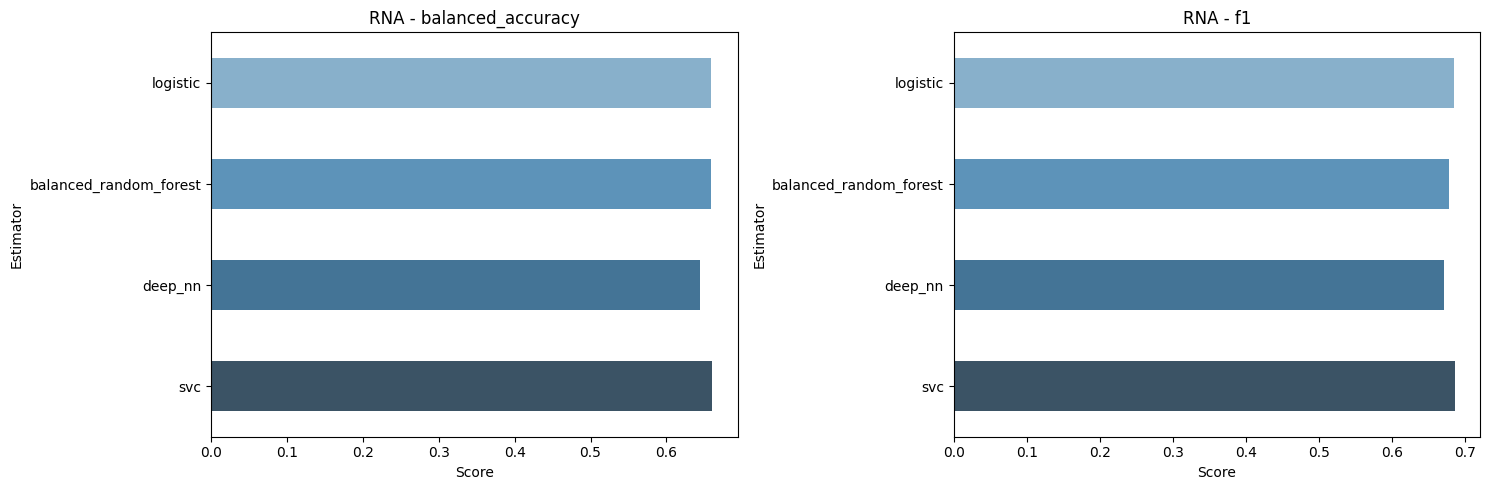

In [19]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

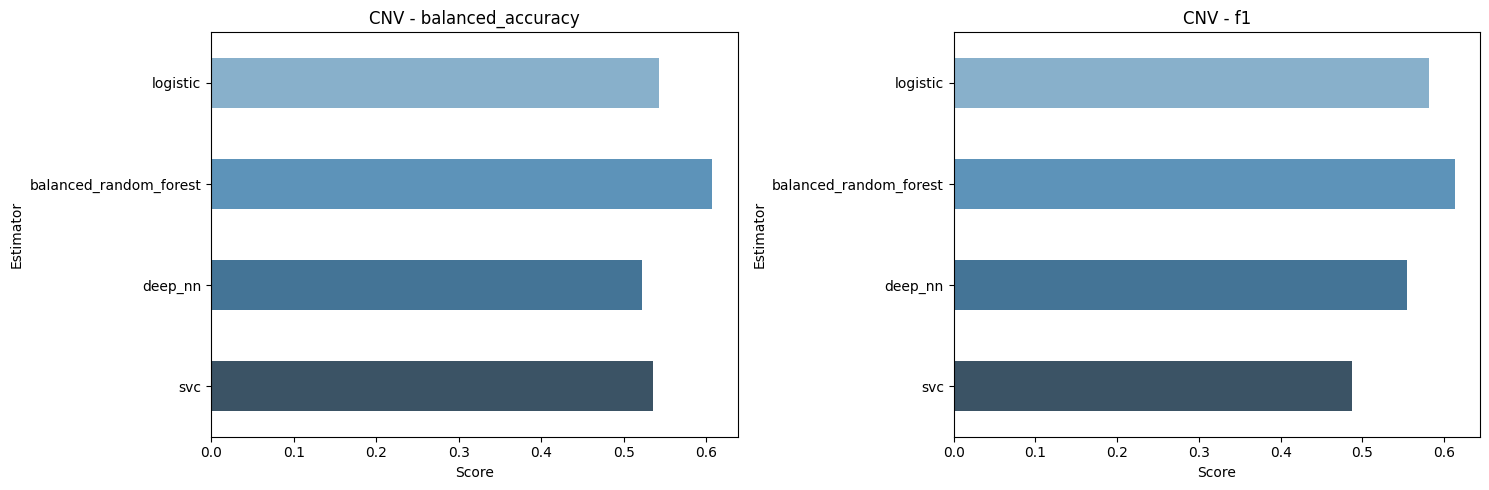

In [20]:
plot_bar_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

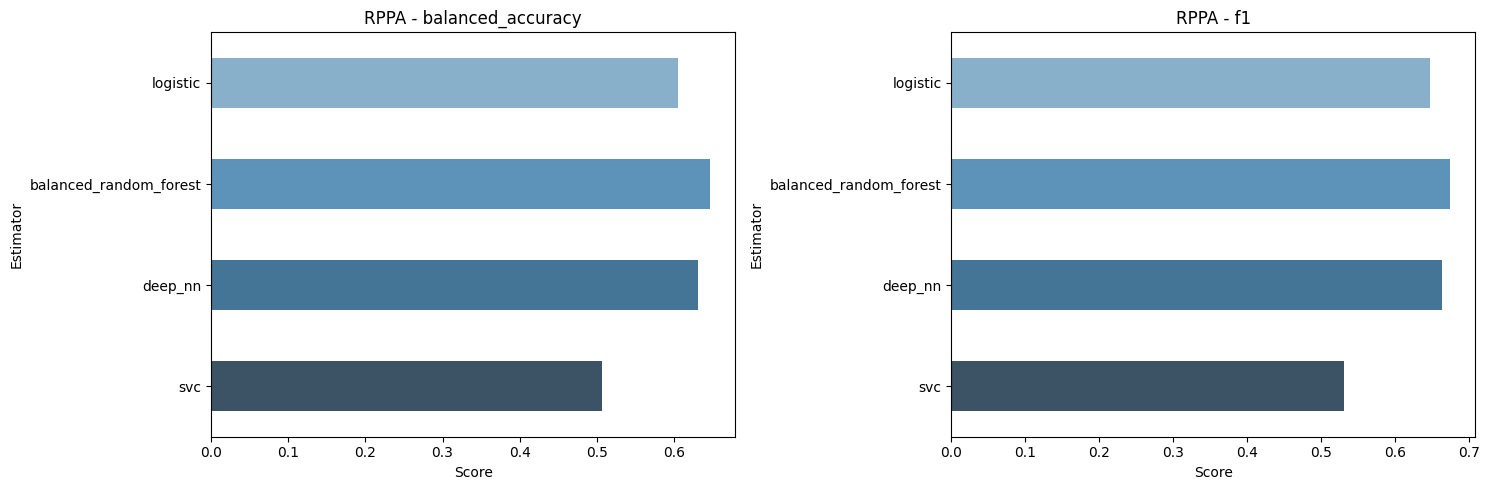

In [21]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

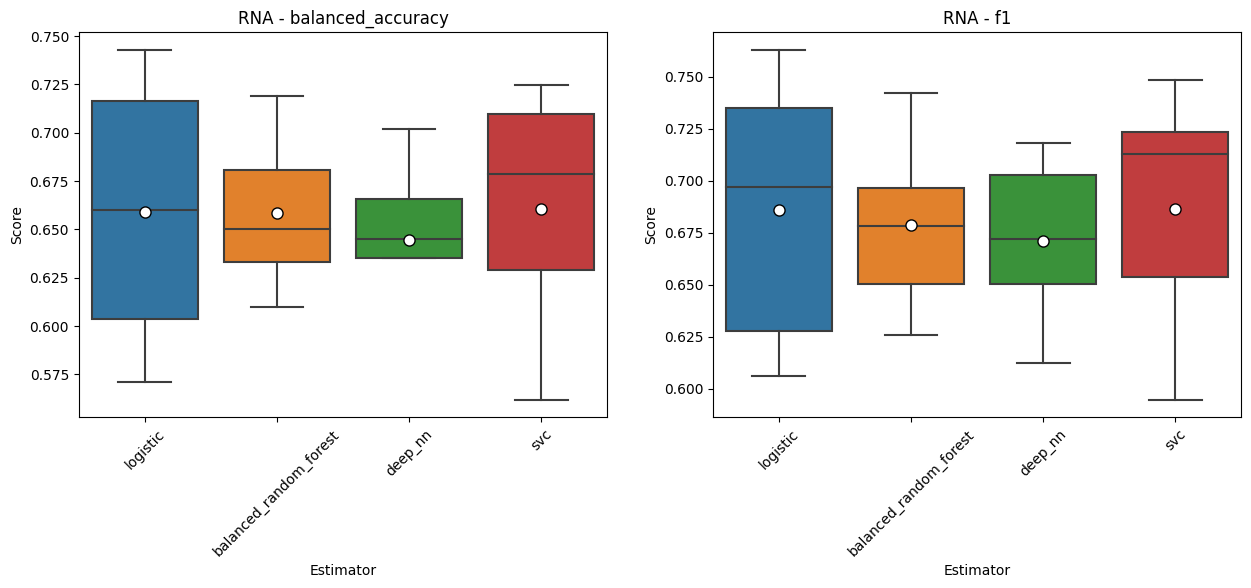

In [22]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

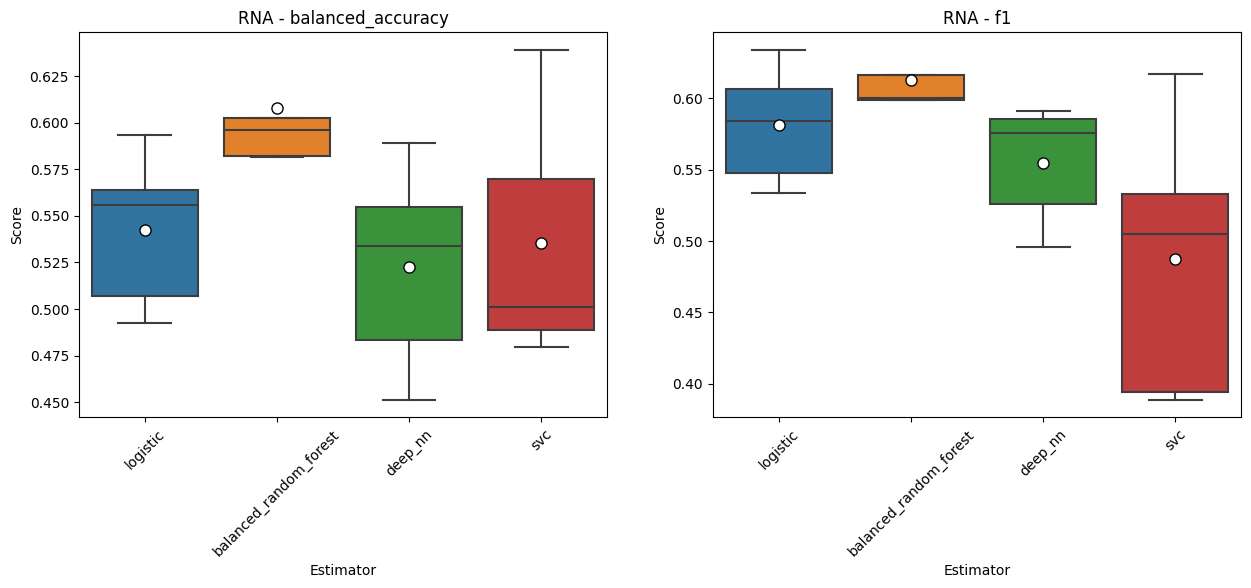

In [23]:
plot_box_scores(estimator_names, base_scores['cnv'], 'RNA', metrics=['balanced_accuracy', 'f1'])

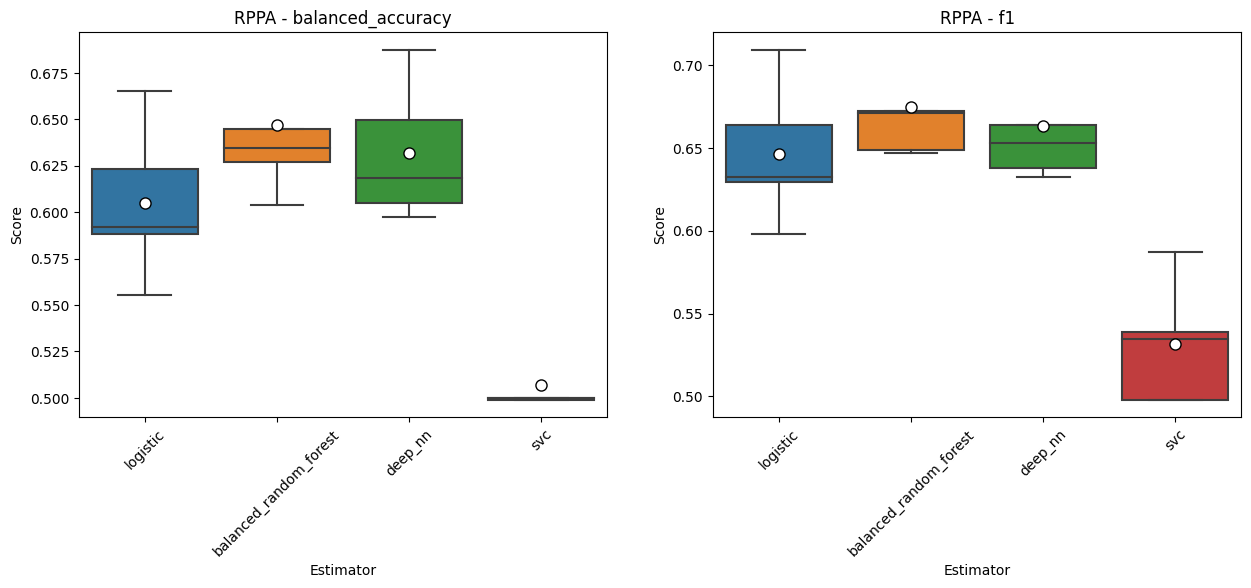

In [24]:
plot_box_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

## Modality Ensembles

In [17]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [36]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring=kipan_stage_scoring)
    modality_metrics = pd.concat([modality_metrics, df])

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.w

In [29]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (early),recall (late)
rna,0.751 +/- 0.033,0.715 +/- 0.025,0.746 +/- 0.032,0.843 +/- 0.035,0.586 +/- 0.054
cnv,0.633 +/- 0.066,0.549 +/- 0.022,0.590 +/- 0.056,0.850 +/- 0.104,0.247 +/- 0.101
rppa,0.705 +/- 0.037,0.648 +/- 0.033,0.689 +/- 0.042,0.868 +/- 0.032,0.429 +/- 0.047


In [38]:
import json
import numpy as np

# Convert and write JSON object to file
with open("results/kipan_modality_results.json", "w") as outfile: 
    json.dump(scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)


In [59]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]
all_scores = {}

for modality in base_scores:
    all_scores[modality] = {}
    for i in range(len(base_scores[modality])):
        all_scores[modality][estimator_names[i]] = base_scores[modality][i]
    
    all_scores[modality]['stacking'] = scores[modality]


In [60]:
# Convert and write JSON object to file
with open("results/kipan_base_learner_modality_results.json", "w") as outfile: 
    json.dump(all_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

### Scoring

In [31]:
all_metrics = {}

for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [32]:
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['rppa'])

,accuracy,balanced_accuracy,f1,recall (early),recall (late)
logistic,0.701 +/- 0.048,0.659 +/- 0.065,0.686 +/- 0.060,0.818 +/- 0.087,0.500 +/- 0.173
balanced_random_forest,0.689 +/- 0.041,0.658 +/- 0.038,0.679 +/- 0.040,0.772 +/- 0.128,0.544 +/- 0.159
deep_nn,0.685 +/- 0.027,0.644 +/- 0.042,0.671 +/- 0.038,0.796 +/- 0.093,0.493 +/- 0.155
svc,0.702 +/- 0.037,0.661 +/- 0.059,0.687 +/- 0.055,0.818 +/- 0.082,0.504 +/- 0.177
rna,0.751 +/- 0.033,0.715 +/- 0.025,0.746 +/- 0.032,0.843 +/- 0.035,0.586 +/- 0.054


,accuracy,balanced_accuracy,f1,recall (early),recall (late)
logistic,0.602 +/- 0.054,0.542 +/- 0.037,0.581 +/- 0.037,0.766 +/- 0.113,0.319 +/- 0.076
balanced_random_forest,0.626 +/- 0.060,0.608 +/- 0.035,0.613 +/- 0.051,0.678 +/- 0.194,0.537 +/- 0.198
deep_nn,0.575 +/- 0.048,0.522 +/- 0.049,0.555 +/- 0.037,0.719 +/- 0.123,0.326 +/- 0.160
svc,0.499 +/- 0.074,0.536 +/- 0.061,0.488 +/- 0.087,0.397 +/- 0.154,0.674 +/- 0.144
cnv,0.633 +/- 0.066,0.549 +/- 0.022,0.590 +/- 0.056,0.850 +/- 0.104,0.247 +/- 0.101


,accuracy,balanced_accuracy,f1,recall (early),recall (late)
logistic,0.664 +/- 0.038,0.605 +/- 0.037,0.647 +/- 0.038,0.828 +/- 0.041,0.381 +/- 0.038
balanced_random_forest,0.682 +/- 0.027,0.647 +/- 0.041,0.674 +/- 0.031,0.779 +/- 0.066,0.515 +/- 0.127
deep_nn,0.670 +/- 0.038,0.632 +/- 0.033,0.663 +/- 0.035,0.774 +/- 0.073,0.489 +/- 0.072
svc,0.529 +/- 0.036,0.507 +/- 0.028,0.531 +/- 0.033,0.588 +/- 0.080,0.426 +/- 0.071
rppa,0.705 +/- 0.037,0.648 +/- 0.033,0.689 +/- 0.042,0.868 +/- 0.032,0.429 +/- 0.047


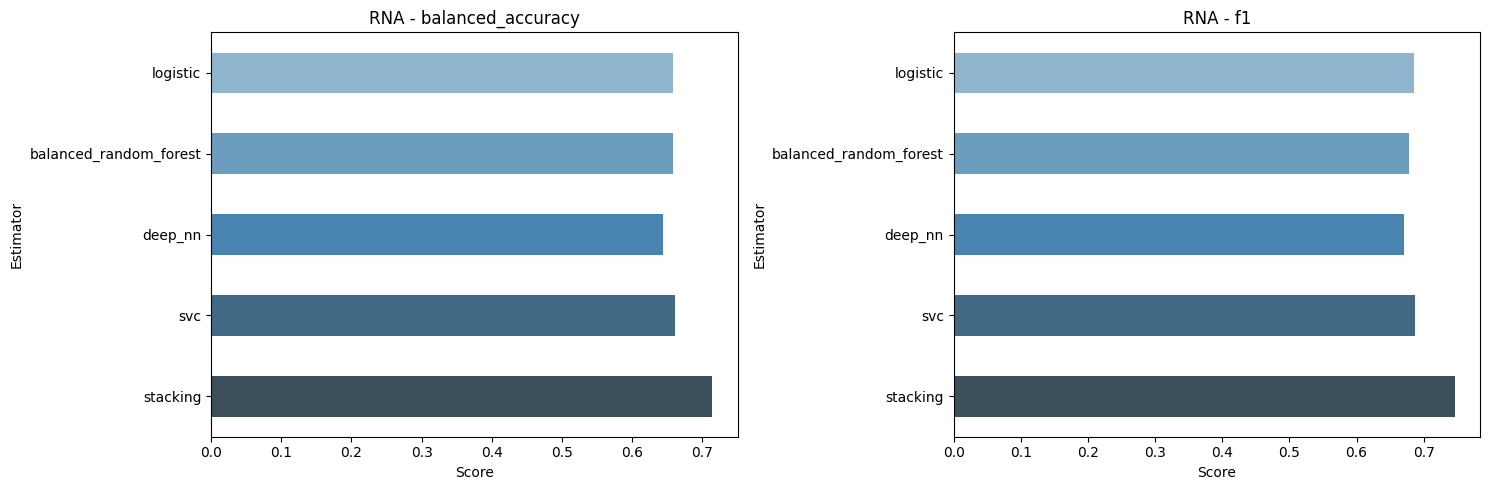

In [33]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

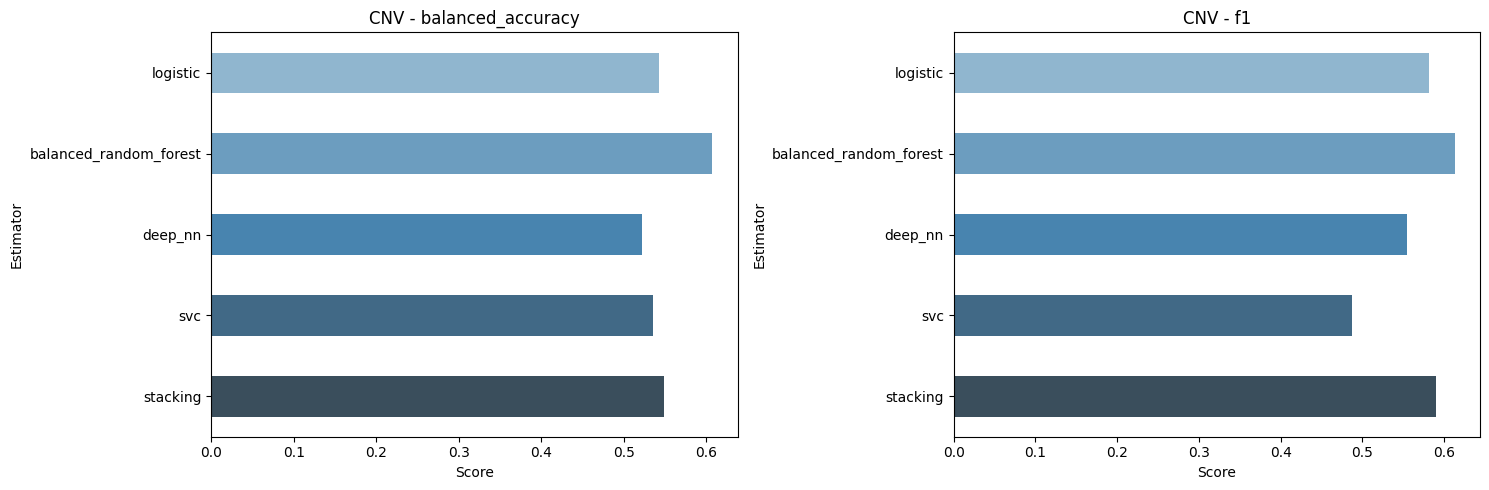

In [34]:
plot_bar_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

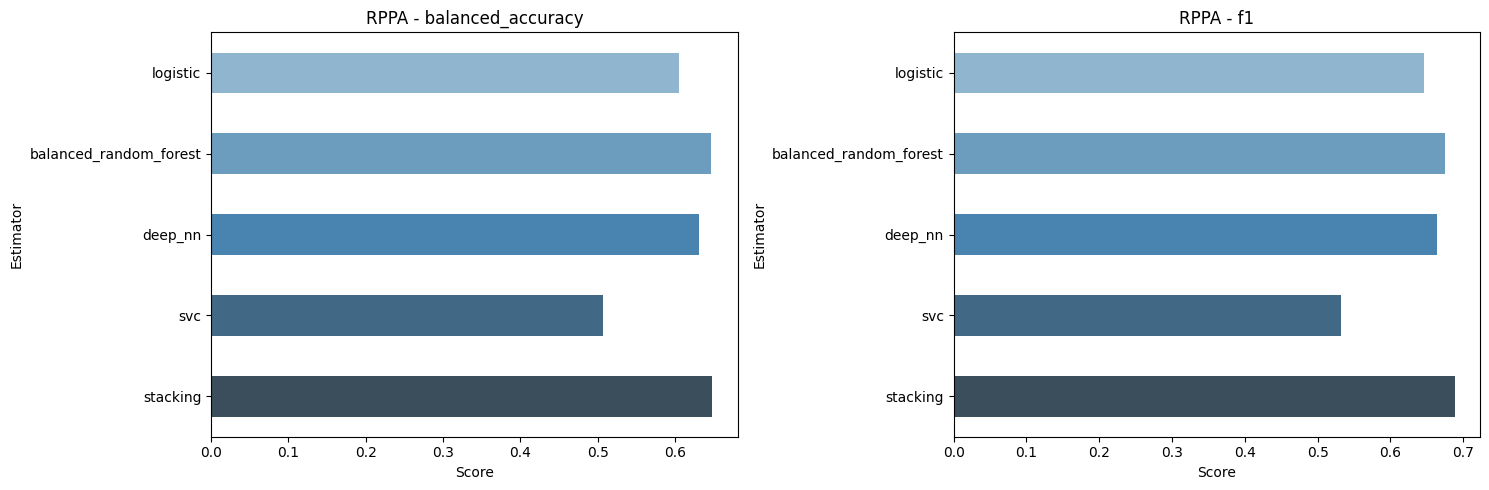

In [35]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

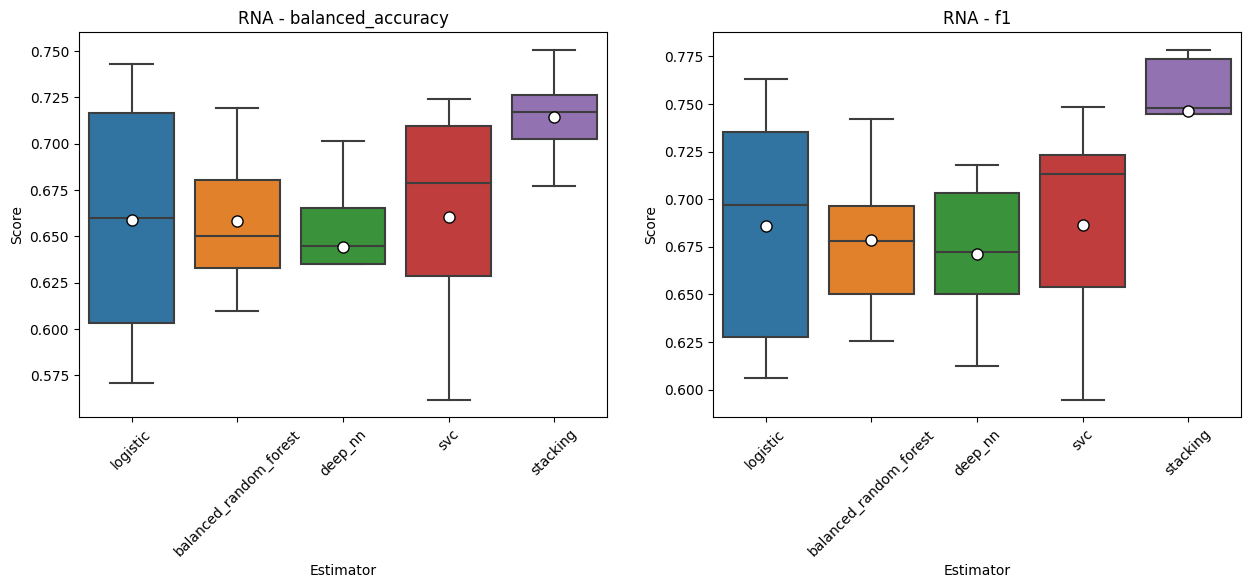

In [36]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

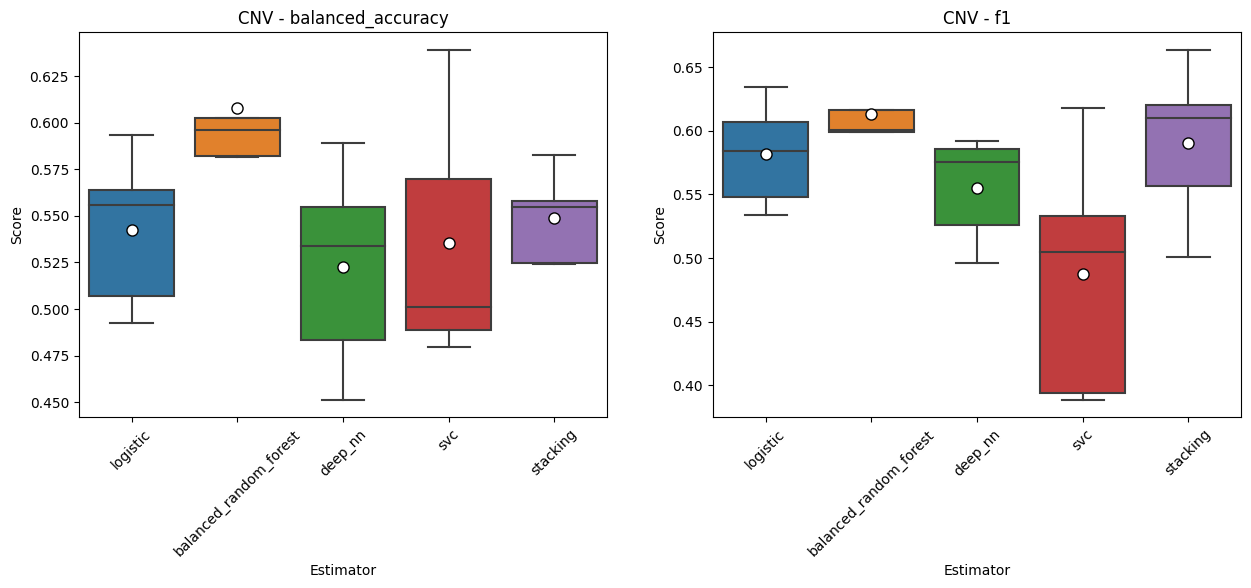

In [37]:
plot_box_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

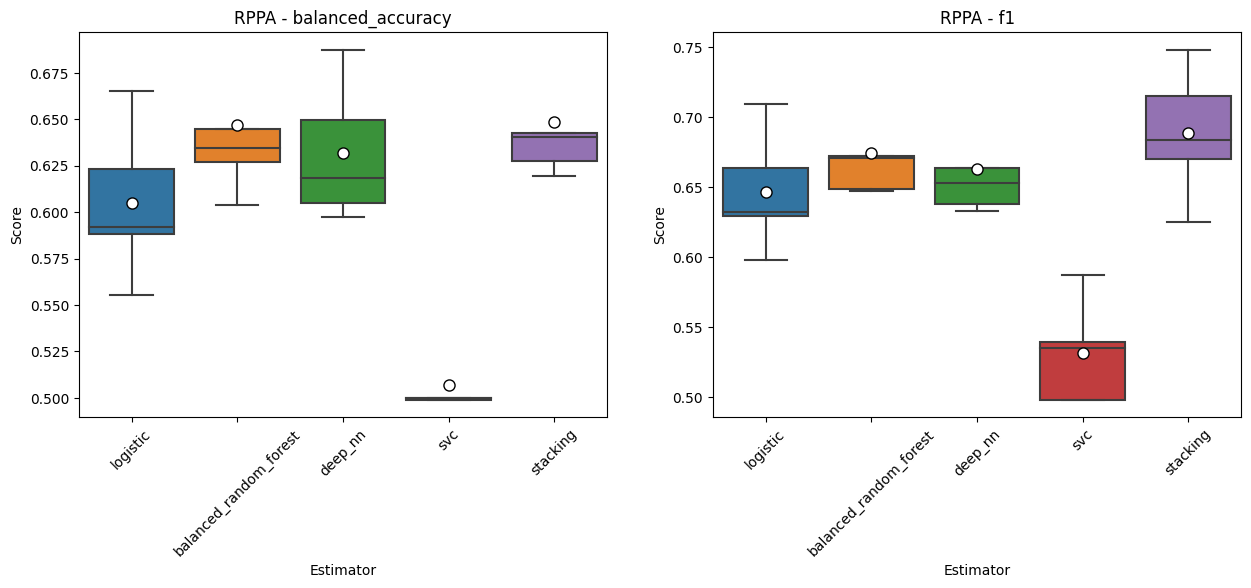

In [38]:
plot_box_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

## Multi Omics Integration Ensemble

In [14]:
from mlxtend.feature_selection import ColumnSelector

class MultiOmicsIntegrationClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, estimator_dict=None, feature_select=None, final_estimator=LogisticRegression(random_state=0, n_jobs=-1), stack_method='auto', cv=5, n_jobs=-1):
        # calculating scores
        self.estimator_dict = estimator_dict
        self.feature_select = feature_select
        self.final_estimator = final_estimator
        self.stack_method = stack_method
        self.cv = cv
        self.n_jobs = n_jobs
        
    def _get_pipeline(self):
        self.classifiers_ = []
        self.cv_ = StratifiedKFold(n_splits=self.cv, random_state=0, shuffle=True)
        
        for dataset, columns in self.column_names_.items():
            stacking = Pipeline([('column_selector', ColumnSelector(cols=columns)), ('modality_clf', self.estimator_dict[dataset])])
            self.classifiers_.append((dataset, stacking))
        
        self.final_estimator_ = Pipeline([('imputer', SimpleImputer(strategy='median')), ('final_estimator', self.final_estimator)])
        stacking = StackingClassifier(estimators=self.classifiers_, final_estimator=self.final_estimator_, cv=self.cv_, stack_method=self.stack_method, n_jobs=self.n_jobs)
        
        return stacking
    
    def fit(self, X, y, column_names=None, **fit_params):
        
        self.column_names_ = column_names

        self.pipeline_ = self._get_pipeline()
        self.pipeline_.fit(X, y)

        return self
    
    def predict(self, X):
        return self.pipeline_.predict(X)
    
    def predict_proba(self, X):
        return self.pipeline_.predict_proba(X)

In [15]:
column_names = {}

for key in X.keys():
    column_names[key] = X[key].columns

In [18]:
meta_ensembles = {}
meta_ensembles['rna + cnv + rppa'] = MultiOmicsIntegrationClassifier(classifiers, cv=3)
meta_ensembles['cnv + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['cnv', 'rppa']}, cv=3)
meta_ensembles['rna + cnv'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'cnv']}, cv=3)
meta_ensembles['rna + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'rppa']}, cv=3)

In [19]:
X_merged = {}
X_merged['rna + cnv + rppa'] = pd.concat([X['rna'], X['cnv'], X['rppa']], axis=1, join='inner')
X_merged['cnv + rppa'] = pd.concat([X['cnv'], X['rppa']], axis=1, join='inner')
X_merged['rna + cnv'] = pd.concat([X['rna'], X['cnv']], axis=1, join='inner')
X_merged['rna + rppa'] = pd.concat([X['rna'], X['rppa']], axis=1, join='inner')


In [20]:
integration_scores = {}
integration_metrics = {}

In [21]:
integration_scores['rna + cnv + rppa'], integration_metrics['rna + cnv + rppa'] = get_cross_metrics(meta_ensembles['rna + cnv + rppa'], X_merged['rna + cnv + rppa'], y, name='rna + cnv + rppa', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': column_names})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings

[CV] END .................................................... total time=22.2min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .................................................... total time=23.2min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 23.4min remaining: 35.0min
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .................................................... total time=23.6min
[CV] END .................................................... total time=23.8min
[CV] END .................................................... total time=24.0min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 24.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 24.1min finished


In [26]:
integration_scores['cnv + rppa'], integration_metrics['cnv + rppa'] = get_cross_metrics(meta_ensembles['cnv + rppa'], X_merged['cnv + rppa'], y, name='cnv + rppa', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['cnv', 'rppa']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings

[CV] END .................................................... total time= 5.7min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .................................................... total time= 5.8min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.8min remaining:  8.7min
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .................................................... total time= 5.8min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

[CV] END .................................................... total time= 6.5min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users

[CV] END .................................................... total time= 6.9min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.9min finished


In [29]:
integration_scores['rna + rppa'], integration_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'rppa']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users

[CV] END .................................................... total time=12.2min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

[CV] END .................................................... total time=13.3min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.4min remaining: 20.1min
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .................................................... total time=13.6min
[CV] END .................................................... total time=13.8min
[CV] END .................................................... total time=14.0min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.1min finished


In [31]:
integration_scores['rna + cnv'], integration_metrics['rna + cnv'] = get_cross_metrics(meta_ensembles['rna + cnv'], X_merged['rna + cnv'], y, name='rna + cnv', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'cnv']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with Stand

[CV] END .................................................... total time=20.8min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .................................................... total time=22.5min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 22.6min remaining: 34.0min
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .................................................... total time=23.2min
[CV] END .................................................... total time=23.5min
[CV] END .................................................... total time=23.8min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 23.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 23.9min finished


In [49]:
all_integration_metrics = pd.concat([modality_metrics, pd.concat([x for x in integration_metrics.values()])])
names = ['rna', 'cnv', 'rppa', 'rna + cnv + rppa', 'cnv + rppa', 'rna + rppa', 'rna + cnv']

all_integration_scores = scores

# Adding multi-omic ensemble scores
for name, value in integration_scores.items():
    all_integration_scores[name] = value

In [34]:
integration_scores

{'rna + cnv + rppa': {'fit_time': array([1413.77401114, 1428.02523708, 1438.75724316, 1390.76214004,
         1325.97617197]),
  'score_time': array([3.41427898, 2.1368382 , 1.79120994, 4.19281602, 4.6462009 ]),
  'test_accuracy': array([0.77702703, 0.66666667, 0.7414966 , 0.76870748, 0.79591837]),
  'test_balanced_accuracy': array([0.74728261, 0.64043675, 0.71445176, 0.73752577, 0.72142857]),
  'test_f1': array([0.77248434, 0.65044092, 0.73617813, 0.76752742, 0.78892185]),
  'test_recall (early)': array([0.86956522, 0.84337349, 0.84269663, 0.83505155, 0.8952381 ]),
  'test_recall (late)': array([0.625     , 0.4375    , 0.5862069 , 0.64      , 0.54761905])},
 'cnv + rppa': {'fit_time': array([338.62985277, 350.32307124, 347.12935901, 389.05043721,
         415.75368381]),
  'score_time': array([0.60589314, 0.40479374, 0.47138214, 0.2795608 , 0.23695016]),
  'test_accuracy': array([0.70945946, 0.6462585 , 0.70068027, 0.71428571, 0.73469388]),
  'test_balanced_accuracy': array([0.6754658

In [50]:
import json
import numpy as np
# Convert and write JSON object to file
with open("results/kipan_multi_omics_results.json", "w") as outfile: 
    json.dump(integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)


In [51]:
# Convert and write JSON object to file
with open("results/kipan_modality_multi_omics_results.json", "w") as outfile: 
    json.dump(all_integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [42]:
all_integration_metrics

,accuracy,balanced_accuracy,f1,recall (early),recall (late)
rna,0.751 +/- 0.033,0.715 +/- 0.025,0.746 +/- 0.032,0.843 +/- 0.035,0.586 +/- 0.054
cnv,0.633 +/- 0.066,0.549 +/- 0.022,0.590 +/- 0.056,0.850 +/- 0.104,0.247 +/- 0.101
rppa,0.705 +/- 0.037,0.648 +/- 0.033,0.689 +/- 0.042,0.868 +/- 0.032,0.429 +/- 0.047
rna + cnv + rppa,0.750 +/- 0.045,0.712 +/- 0.038,0.743 +/- 0.049,0.857 +/- 0.022,0.567 +/- 0.072
cnv + rppa,0.701 +/- 0.030,0.648 +/- 0.022,0.686 +/- 0.039,0.853 +/- 0.025,0.444 +/- 0.069
rna + rppa,0.754 +/- 0.044,0.715 +/- 0.037,0.746 +/- 0.048,0.866 +/- 0.030,0.564 +/- 0.072
rna + cnv,0.742 +/- 0.031,0.703 +/- 0.022,0.736 +/- 0.031,0.841 +/- 0.032,0.564 +/- 0.058


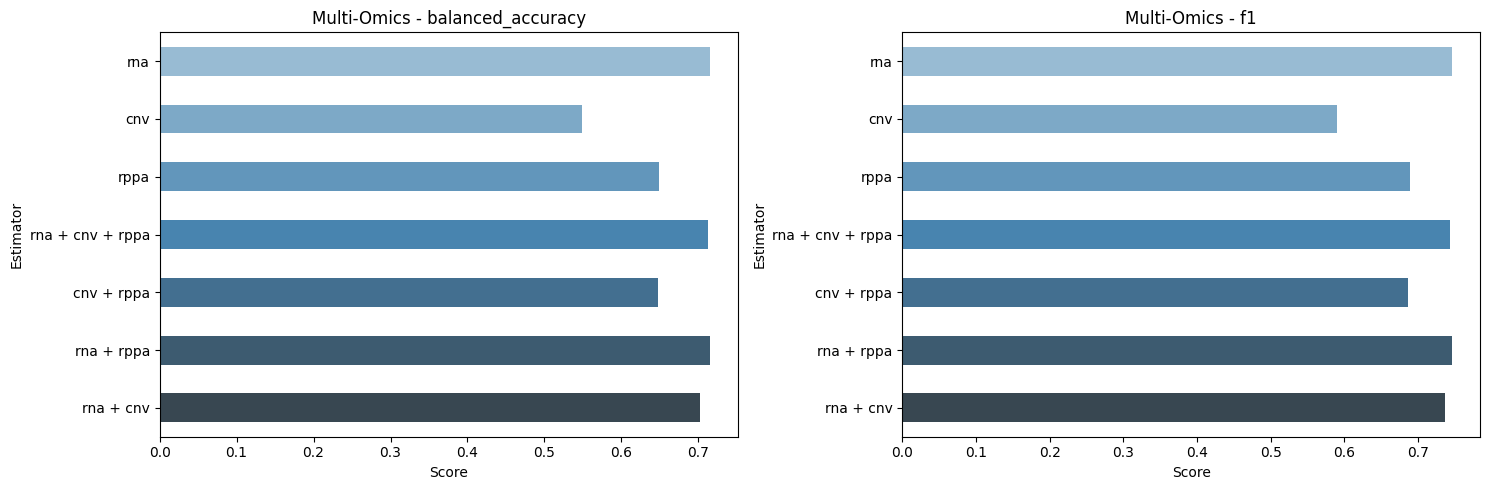

In [44]:
plot_bar_scores(names, all_integration_scores, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

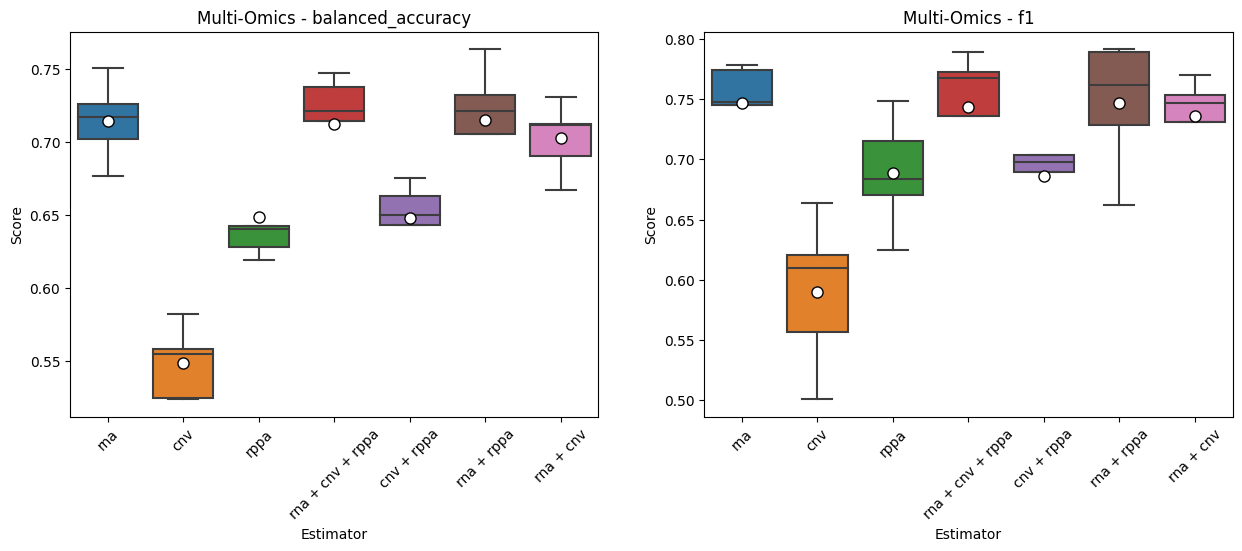

In [45]:
plot_box_scores(names, all_integration_scores, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])